In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1



# SST.X620

Predictions of monthly mean SST from SST
Generalization to N fields
Using SST, T2M, Z500, U850, V850
Global Tropics 
 
Using climformer from library

Version with optional comparison with dynamical models
Version with verification standard
Version with Tpredict different from training interval T

Based on PYTORCH

* Duplicate of X619 plus comparison with dynamical forecasts

 Attempt to put different weights in the loss function


In [3]:
import os,sys
import math
import pickle
import tabulate as tab
import datetime
import time as tm
import random

import matplotlib.pyplot as plt
from collections  import namedtuple


import numpy as np
import scipy.linalg as sc
import scipy.signal as sig
import numpy.linalg as lin
from scipy import stats
from scipy.signal import argrelextrema

from alive_progress import alive_bar
import time

import xarray as xr
import pandas as pd

import numpy.polynomial.polynomial as poly

# AI Imports
from sklearn import datasets		# To Get iris dataset
from sklearn import svm   
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import transformers as tr
# import torch.nn.functional as F

# insert at 1, 0 is the script path (or '' in REPL)
homedir = os.path.expanduser("~")
print('Root Directory for Data ',homedir)
drop_home = '/CMCC Dropbox/Antonio Navarra'
sys.path.insert(1, homedir + drop_home + '/ZapataLibrary/Zapata')


#Working Directory
wkdir =  drop_home + '/AI'
dddir =  drop_home + '/ERA5_DATA'

os.chdir(homedir + wkdir)
print('Working Directory set to ',os.getcwd())

# import klus.algorithms as al
# # import d3s.domain as domain
# import klus.kernels as kernels
# # import d3s.tools as tools

import zapata.computation as zcom
import zapata.data as zd
import zapata.lib as zlib
import zapata.mapping as zmap
import AIModels.AIutil as zai
import AIModels.AIClasses as zaic
import AIModels.ClimFormer as zcf
import AIModels.UtilPlot as utp
import AIModels.ModelTraining as mtr
import AIModels.LocalInformer as ltr




from scipy.spatial import distance
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

env = zlib.get_environment_info('interpreter')
print(f'\n\nNotebook operating in ENV {env}\n')

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline


Root Directory for Data  /Users/antonionavarra
Working Directory set to  /Users/antonionavarra/CMCC Dropbox/Antonio Navarra/AI


Notebook operating in ENV /Users/antonionavarra/opt/anaconda3/envs/AIDEV/bin/python



## Input data from ERA5

Definiton of Areas and Period

Choice of encoding and variance retained

## Prepare data

The training data is read using a definition of a class that defines which data are read in which field, and how many EOF, and which region of the word is selected, including level. This class is contained into the *AIutil* class module and is called **Field**.


In [6]:
# Configure case

case = 'X620'

shift = 'ERA5'      # Choose data period
SMOOTH = False       # Apply seasonal filter
period = 'ANN'      # Annual or season
data_name= case 
normalization = 'anom'  #Normalization for the EOF
write_result = False    # Write esults to netcdf file
only_valtrain_eof = True  # Use only training and validation for EOF
verify_dyn = True  #  Verify against dynamical forecasts
choose_device = 'MPS' #'GPU'   # choose if 'CPU' or 'GPU'
# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None # 0.99#.99#

# Reproducibility
torch.manual_seed(46963291)

#Select period for EOF:
if only_valtrain_eof:
    #Use only training and validation for EOF:
    if SMOOTH:
        eof_interval =['1940-03-01','2015-12-01']
    else:
        eof_interval =['1940-01-01','2015-12-01']
else:
    eof_interval = None   # Use all data

#Select variables:

# [SST,T2M], Smooth, [8,16]
Z200 = zaic.Field('Z',['200'],'NH-ML',12)
# V850 = zaic.Field('V',['850'],'NH-ML',10)
# U850 = zaic.Field('U',['850'],'NH-ML',10)
Z850 = zaic.Field('Z',['850'],'EUROPE',12)
Z500 = zaic.Field('Z',['500'],'NH-ML',12)
T2M = zaic.Field('t2m',['t2m'],'EUROPE',20)
SP = zaic.Field('SP',['SP'],'WORLD',15)
SST = zaic.Field('SST',['SST'],'TROPIC',15)
InputVars = [SP,SST]
PredictVars = [SP, SST]



# Write case configuration
caseid =  {'case':case, 'version':'V5', 'SMOOTH':SMOOTH, 'normalization':normalization,\
           'only_valtrain_eof':only_valtrain_eof, 'eof_interval':eof_interval,\
           'shift':shift,'period':period, 'InputVars':InputVars,'PredictVars':PredictVars}

The input variable are then collected within a dictionary **INX** that contains all the variables and the information that are necessary for the analysis. Another Dictionary **caseid** contains the basic information, identifying the options and the configuration of these analysis.

In [8]:
#Input variables data base
invar_dict = {'period':'ANN', 'version':'V5', 'SMOOTH':SMOOTH, 'normalization':normalization, 'detrend':False,\
              'eof_interval':eof_interval, 'shift':'ERA5', 'case':case, 'datatype':'Source_data','location':homedir+dddir}
INX=zai.make_data_base(InputVars, **invar_dict)

Directory  /Users/antonionavarra/CMCC Dropbox/Antonio Navarra/ERA5_DATA/DATA_CACHE  Already Exists
Selected data from 1940-01-01T00:00:00.000000000 to 2022-12-01T00:00:00.000000000 

Use Pacific centered coordinates with centlat=180
Selecting field SP for level SP and area WORLD
{'dropnan': False, 'detrend': False}
Created data Matrix X, stacked along dimensions ('lat', 'lon') 
Option DropNaN False -- Shape of Xmat (577440, 996)
EOF interval defined -- Using data from 1940-01-01 to 2015-12-01
make_eof: -- EOF interval defined -- Using data from 1940-01-01 to 2015-12-01
make_eof: -- EOF interval defined -- Using data from 0 to 911
  Number of SVD modes retained 15, rank of matrix 911
Variance Retained 0.75 out of possible 911 modes
 Condition number 942.9695123662992
Added field `SP` with identification `SPSP` to data base
Directory  /Users/antonionavarra/CMCC Dropbox/Antonio Navarra/ERA5_DATA/DATA_CACHE  Already Exists
Selected data from 1940-01-01T00:00:00.000000000 to 2022-12-01T00:0

In [9]:
#Predicted variables data base
pred_dict =  {'period':'ANN', 'version':'V5', 'SMOOTH':SMOOTH, 'normalization':normalization, 'detrend':False,\
              'eof_interval':eof_interval, 'shift':'ERA5', 'case':case, 'datatype':'Target_data','location':homedir+dddir}

#Save space
# PDX=zai.make_data_base(PredictVars, **pred_dict)
PDX = INX

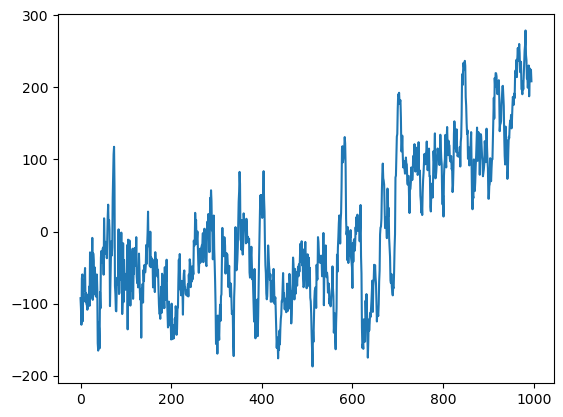

In [10]:
#Verification variables data base
# SSTver = zaic.Field('SST',['SST'],'TROPIC',math.inf)

# ver_dict = {'period':'ANN', 'version':'V5', 'SMOOTH':SMOOTH, 'normalization':normalization, \
#                    'shift':'ERA5', 'case':case, 'datatype':'Target_data','location':homedir+dddir}
# #Save space
# VEX=zai.make_data_base([SSTver], **ver_dict)
plt.plot(INX['SSTSST']['vdat'][1,:])

In [11]:
# Obtain time dates from data chosen
field1 = list(INX.keys())[0]
fd = INX[field1]['X'].A.time.data[0]
fl = INX[field1]['X'].A.time.data[-1]
pd.Timestamp(fd), pd.Timestamp(fl)
data_time = pd.date_range(start=fd, end=fl, freq='1MS')
data_time_str = data_time.strftime('%Y-%m-%d')

In [12]:
# Configure AI Model
# Find total number of features and boundaries
num_features_src, m_lim_src = zai.make_features(INX) 
# Find total of features in target
num_features_tgt, m_lim_tgt = zai.make_features(PDX) 


Processing field SP that is Source_data
Limit for SP is 15

Processing field SST that is Source_data
Limit for SST is 15
Total number of features  30

Processing field SP that is Source_data
Limit for SP is 15

Processing field SST that is Source_data
Limit for SST is 15
Total number of features  30


In [13]:
params ={'TIN':48,'MIN':num_features_src,'T':12,'K':num_features_tgt,'EPOCHS':400,'RESTART':False, 'D_DIM':512, 'Tpredict':12,
         'FFN_DIM':512,'ENC_Heads':2,'DEC_Heads':2, 'enc_dec_layers':1, 'scaling':'MaxMin',
         'LR':0.00005,'WD':0.1,'savefile':None}
params['savefile'] = f"informer_{case}_{normalization}_{params['enc_dec_layers']}_{params['D_DIM']}_{params['TIN']}_{SMOOTH}"

TIN = params['TIN']  # Number of input timestep47
MIN = params['MIN']   # Number of input features
T = params['T']    # Number of output timesteps
K = params['K']    # Number of predicted features
num_epochs = params['EPOCHS'] 
RESTART = params['RESTART']
Tpredict = params['Tpredict']
# LAGS =[1,3,6,8,12]
LAGS = [1,3,6,9]
params['lags'] = LAGS
CONTEXT = TIN - max(LAGS)
assert CONTEXT > 0, 'Value of LAGS wrong'
print(f' Chosen context is {CONTEXT}, for max(lags)  {max(LAGS)}')

learning_rate = params['LR'] 

file = 'MOD_' + params['savefile'] + '.pt'
FIGfile =  'FIG_' + params['savefile'] + '.pdf'

batch_size = 16
torch.manual_seed(17553984)

match choose_device:
    case 'CPU':
        device = torch.device('cpu')
        t_type = torch.float32
    case 'MPS':
        device = torch.device('mps')
        t_type = torch.float32
    case _:
        device = torch.device('cpu')
        t_type = torch.float32
torch.set_default_dtype(t_type)
params['t_type'] = t_type
params['device'] = device
#
#
# The Convention for indeces is that they point to the real date.
# I python ranges need to be defined then it must take into account the extra 1
data_time.get_loc(fd)

start_date = data_time_str[0]
end_training = '2005-12-01'

start_val = '2006-01-01'
end_val = '2015-12-01'

test_start = '2016-01-01'
test_end = '2022-12-01'

print(f'Training \tfrom \t{start_date} \tto \t{end_training} \nValidation \tfrom \t{start_val} \tto \t{end_val} \nTesting \tfrom \t{test_start} \tto \t{test_end}\n')

train_period_start = data_time.get_loc(start_date)
train_period_end = data_time.get_loc(end_training)
val_period_start = data_time.get_loc(start_val)
val_period_end = data_time.get_loc(end_val)
test_period_start = data_time.get_loc(test_start)
test_period_end = data_time.get_loc(test_end)

params |= {'start_date':start_date,'end_training':end_training, 'start_val':start_val,'end_val':end_val,'test_start':test_start,'test_end':test_end, \
        'train_period_start':train_period_start,'train_period_end':train_period_end, 'val_period_start':val_period_start, 'val_period_end':val_period_end,'test_period_start':test_period_start, 'test_period_end':test_period_end}


print(f'Absolute Indices for \nTraining \t{train_period_start}\tto \t{train_period_end}\nValidation \t{val_period_start}\tto \t{val_period_end}\nTest \t\t{test_period_start}\tto \t{test_period_end}\n')
print(f'Range Indices for \nTraining \t{train_period_start}\tto \t{train_period_end+1}\nValidation \t{val_period_start}\tto \t{val_period_end+1}\nTest \t\t{test_period_start}\tto \t{test_period_end+1}\n')


print(f'Data Extent in Training {(train_period_end-train_period_start)+1}')
print(f'Data Extent in Validation {(val_period_end-val_period_start)+1}')
print(f'Data Extent in Test {(test_period_end-test_period_start)+1}')


# Define range indices for forecasting sequences
params['train_first_fcs'] = TIN                           # First forecasted month for first forecast 
params['train_last_fcs'] = params['train_period_end'] - Tpredict   +2     # First forecasted month for last forecast 
params['val_first_fcs'] = params['val_period_start']  + TIN    
params['val_last_fcs'] = params['val_period_end'] - Tpredict    +2    
params['test_first_fcs'] = params['test_period_start']  + TIN
params['test_last_fcs'] = params['test_period_end'] - Tpredict    +2   
print(f'Starting indices for the sequences in training and forecasts\n')
print(f"TESTING -- \tFirst forecasted month for first forecast {params['test_first_fcs']} \t--> {data_time[params['test_first_fcs']]}\
                    \n\t\tFirst forecasted month for last forecast {params['test_last_fcs']} \t--> {data_time[params['test_last_fcs']]}")
print(f"TRAINING -- \tFirst forecasted month for first forecast {TIN}\t--> {data_time[TIN]}\
                    \n\t\tFirst forecasted month for last forecast {params['train_last_fcs']}\t--> {data_time[params['train_last_fcs']]}")

print(f'Number of forecast cases in each epoch')
print(f"Forecast in Training {params['train_last_fcs']-params['train_first_fcs'] }")
print(f"Forecast in Validation {params['val_last_fcs']-params['val_first_fcs'] }")
print(f"Forecast in Test {params['test_last_fcs']-params['test_first_fcs'] }")

 Chosen context is 39, for max(lags)  9
Training 	from 	1940-01-01 	to 	2005-12-01 
Validation 	from 	2006-01-01 	to 	2015-12-01 
Testing 	from 	2016-01-01 	to 	2022-12-01

Absolute Indices for 
Training 	0	to 	791
Validation 	792	to 	911
Test 		912	to 	995

Range Indices for 
Training 	0	to 	792
Validation 	792	to 	912
Test 		912	to 	996

Data Extent in Training 792
Data Extent in Validation 120
Data Extent in Test 84
Starting indices for the sequences in training and forecasts

TESTING -- 	First forecasted month for first forecast 960 	--> 2020-01-01 00:00:00                    
		First forecasted month for last forecast 985 	--> 2022-02-01 00:00:00
TRAINING -- 	First forecasted month for first forecast 48	--> 1944-01-01 00:00:00                    
		First forecasted month for last forecast 781	--> 2005-02-01 00:00:00
Number of forecast cases in each epoch
Forecast in Training 733
Forecast in Validation 61
Forecast in Test 25


The training, validation, and test are then selected in the following. The time boundaries are absolute limits for this case. They do not take into account either the input sequence or the prediction time Tpredict.

The dictionary **params** contain the time information in the series that correspond to the time location in the data base.

## Plot Input Data

 Opening figure , 2 rows and 1 cols 

Ten Contours automatic
Ten Contours automatic


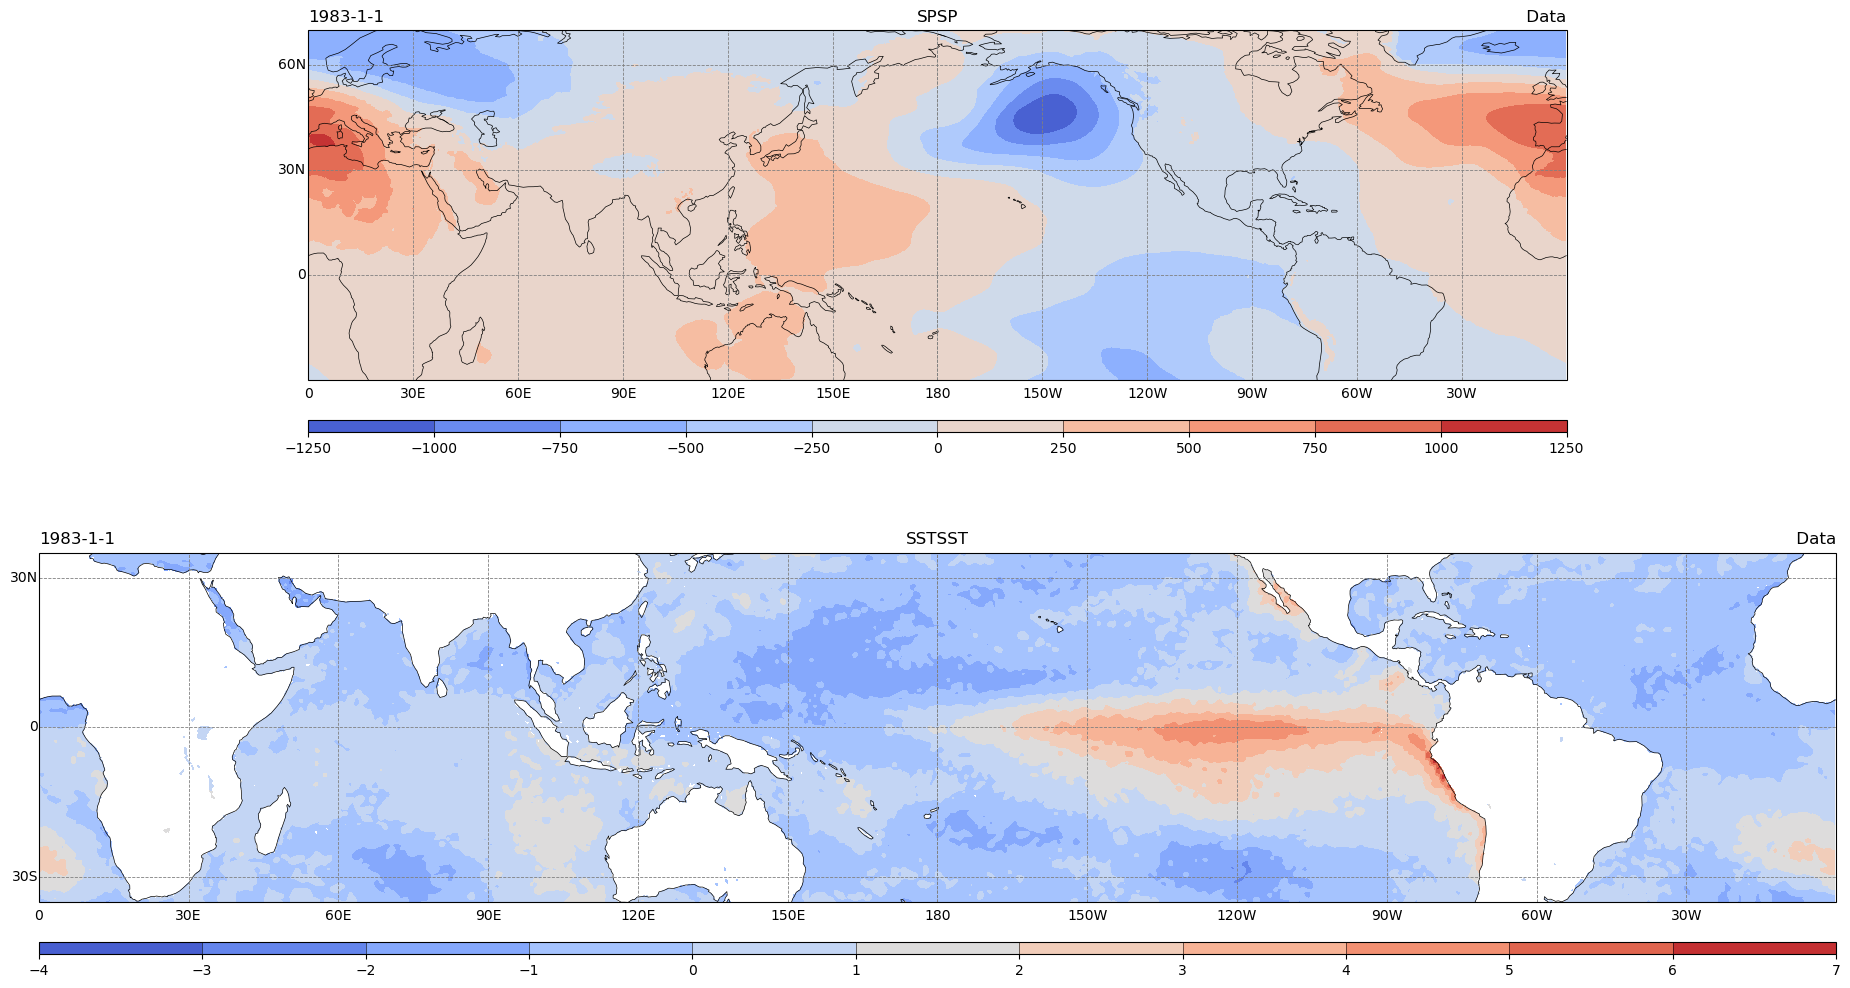

In [16]:
slim=4.0
cont1=[-slim,slim,0.5]
cont2=[-slim,slim,0.5]
cont1=[]
cont2=[]
cont3=[]
label1 = ' Data'
label2 = '1983-1-1'
label3 = '1998-1-1'
    
fig,ax,pro=zmap.init_figure(len(INX.keys()),1,'Pacific', constrained_layout=False, figsize=(24,12) )
for i in enumerate(INX.keys()):
    X,arealat,arealon,centlon = zai.select_field(INX,i[1])
    # "x is greater" if x > y else "y is greater"
    axm = ax if len(INX.keys()) < 2  else ax[i[0]]
    handle=zmap.xmap(X.A.sel(time=label2).unstack(),cont1, pro, ax=axm,refline=None, c_format='{:4.2f}',data_cent_lon=centlon,\
                 xlimit=(arealon[0],arealon[1]), ylimit=(arealat[1],arealat[0]),
                 title={'maintitle':i[1], 'lefttitle':label2,'righttitle':label1},cmap='coolwarm',contour=False)
    zmap.add_colorbar(fig, handle['filled'], axm, label_size=10,edges=True)
fig.subplots_adjust(wspace=0.1,hspace=0.3)
labfile =  f'{data_name}SST{period}.pdf'
plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show()

## Plot EOF coefficients of input fields

SP (577440, 15) (15,) (15, 996)
SST (298511, 15) (15,) (15, 996)


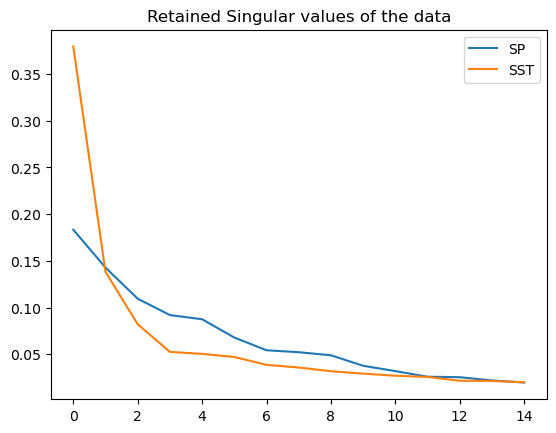

In [18]:
for i in INX.keys():
    print(INX[i]['field'],INX[i]['udat'].shape,INX[i]['sdat'].shape,INX[i]['vdat'].shape)
    plt.plot(INX[i]['sdat']**2/sum(INX[i]['sdat']**2),label=INX[i]['field'])

plt.legend()
plt.title('Retained Singular values of the data')
plt.show()

select_field_eof ---> Extracting EOF data for SST
 Opening figure , 2 rows and 1 cols 

Ten Contours automatic
Ten Contours automatic


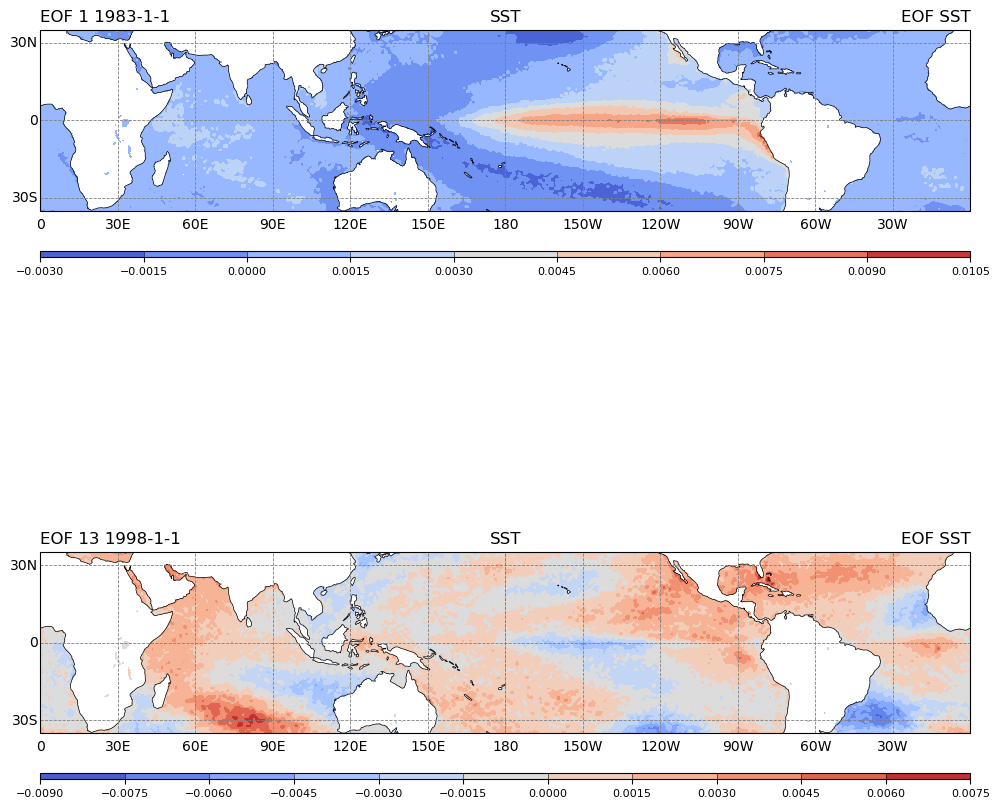

In [19]:
#Plot first EOF of input fields
plfield = 'SSTSST'
Nplfield = INX[plfield]['mr']
udat,_,_ = zai.select_field_eof(INX,plfield)
nameeof = zai.select_field_key(INX,plfield,'field')
utest = INX[plfield]['X'].A.isel(time=slice(0,Nplfield)).copy(data=udat[:,0:Nplfield])
arealon = zai.select_field_key(INX,plfield,'arealon')
arealat = zai.select_field_key(INX,plfield,'arealat')
plpro = 'Pacific'
if INX[plfield]['area'] == 'EUROPE':
    plpro = 'Atlantic'
slim=4.0
cont1=[-slim,slim,0.5]
cont2=[-slim,slim,0.5]
cont1=[]
cont2=[]
label1 = 'EOF ' + nameeof
label2 = f'EOF 1 1983-1-1'
label3 = f'EOF {Nplfield-2} 1998-1-1'
    
fig,ax,pro=zmap.init_figure(2,1,plpro, constrained_layout=False, figsize=(12,12) )
handle=zmap.xmap(utest.isel(time=0).unstack(),cont1, pro, ax=ax[0],refline=None, c_format='{:4.2f}',data_cent_lon=INX[plfield]['centlon'],\
                       xlimit=(arealon[0],arealon[1]), ylimit=(arealat[1],arealat[0]),
                 title={'maintitle':'SST', 'lefttitle':label2,'righttitle':label1},cmap='coolwarm',contour=False)
zmap.add_colorbar(fig, handle['filled'], ax[0], label_size=8,edges=True)
# ax[1].projection = zmap.choose_projection('Atlantic')
han1=zmap.xmap(utest.isel(time=Nplfield-2).unstack(), cont2, plpro, ax=ax[1], refline=None,c_format='{:4.2f}',data_cent_lon=INX[plfield]['centlon'],\
                       xlimit=(arealon[0],arealon[1]),ylimit=(arealat[1],arealat[0]),
               title={'maintitle':'SST', 'lefttitle':label3,'righttitle':label1},cmap='coolwarm',contour=False)
zmap.add_colorbar(fig, han1['filled'], ax[1],label_size=8,edges=True)
fig.subplots_adjust(wspace=0.1,hspace=0.3)
labfile =  f'EOF{data_name}SST{period}.pdf'
# plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show()

## Data Preparation and Input parameters

The total number of features, and the limit in the database, for the different fields are then computed in **make_features**.

In [21]:
# Configure AI Model
# Find total number of features and boundaries
num_features_src, m_lim_src = zai.make_features(INX) 
# Find total of features in target
num_features_tgt, m_lim_tgt = zai.make_features(PDX) 


Processing field SP that is Source_data
Limit for SP is 15

Processing field SST that is Source_data
Limit for SST is 15
Total number of features  30

Processing field SP that is Source_data
Limit for SP is 15

Processing field SST that is Source_data
Limit for SST is 15
Total number of features  30


# Configure the model

## Define Time limit taking into account Tpredict and predictions

The model can have two different future times. *T*  is the time on which the model is trained. The second time is Tpredict. This is the extent of the prediction that is going to be produced by the greedy inference after the model is being evaluated.

The prediction starting time can go only to Tpredict distance from the end training.
And the first forecast start at time *start_test + TIN*


In [23]:

# Split the dataset into train, validation, and test sets
train_size = (train_period_end-train_period_start)+1
val_size = (val_period_end-val_period_start)+1
test_size = (test_period_end-test_period_start)+1

tot_size = (test_period_end-train_period_start)+1
print(f'Train {train_size}, Validation {val_size}, Test {test_size}')
print(f'Check {train_size+val_size+test_size} <---> {tot_size}')

# Split the data into train, validation, and test sets
train_data, val_data, test_data, _ = zai.make_data(INX,params)
tgt_train_data, tgt_val_data, tgt_test_data, _ = zai.make_data(PDX,params)

print(f'\nTensors Train {train_data.shape}, Validation {val_data.shape}, Test {test_data.shape}')
print(f'Check Tensors {train_data.shape[0]+val_data.shape[0]+test_data.shape[0]}')



Train 792, Validation 120, Test 84
Check 996 <---> 996

Processing field SP that is Source_data
select_field_eof ---> Extracting EOF data for SP
vdat (15, 996)
Added field SPSP to feature input data
Index for field SP are 0 and 15

Using MaxMin scaling
Using  15  EOFs for 0.7545802057970274 variance retained

Processing field SST that is Source_data
select_field_eof ---> Extracting EOF data for SST
vdat (15, 996)
Added field SSTSST to feature input data
Index for field SST are 15 and 30

Using MaxMin scaling
Using  15  EOFs for 0.6415086661184584 variance retained
Training data shape torch.Size([792, 30])
Validation data shape torch.Size([120, 30])
Testing data shape torch.Size([84, 30])

Processing field SP that is Source_data
select_field_eof ---> Extracting EOF data for SP
vdat (15, 996)
Added field SPSP to feature input data
Index for field SP are 0 and 15

Using MaxMin scaling
Using  15  EOFs for 0.7545802057970274 variance retained

Processing field SST that is Source_data
select

In [24]:
# Create instances of the time features
tim_train = zai.create_time_features(data_time[:train_size+1], 0, device)
tim_val = zai.create_time_features(data_time[train_size:train_size+val_size+1], 0, device)
tim_test = zai.create_time_features(data_time[train_size+val_size:tot_size+1], 0, device)

# Create instances of the custom dataset for train, validation, and test
train_dataset = zcf.TimeSeriesDataset(train_data, tgt_train_data, TIN, MIN, T, K, time_features=tim_train )
val_dataset = zcf.TimeSeriesDataset(val_data, tgt_val_data, TIN, MIN, T, K, time_features=tim_val )
test_dataset = zcf.TimeSeriesDataset(test_data, tgt_test_data,TIN, MIN, T, K, time_features=tim_test )

# Create data loaders for train, validation, and test sets
train_dataloader = DataLoader(train_dataset,  batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size)

In [25]:
#Create dataloader configuration for prediction
# Only for the test dataset
# Create instances of the custom dataset for train, validation, and test
# pred_dataset = zaic.TimeSeriesDataset(test_data, tgt_test_data, tim_test,TIN, MIN, Tpredict, K)

# # Create data loaders for train, validation, and test sets
# pred_dataloader = DataLoader(pred_dataset,batch_size=batch_size)
len(np.arange(params['test_period_start'],params['test_period_end']+1))

84

### Configuration

In [27]:
# Initializing an Informer configuration with 12 time steps for prediction
# loss_weight can be defined for the loss function as a tensor (batch_size, T), with weights summing to 1
configuration = tr.InformerConfig(prediction_length=T, context_length = CONTEXT, 
                distribution_output = 'student_t', loss = 'nll', 
                input_size = num_features_src,
                output_size = num_features_tgt,
                lags_sequence = LAGS,
                scaling = 'std',
                num_dynamic_real_features = 0, 
                num_static_real_features = 0,
                num_static_categorical_features = 0,
                num_time_features  = 3,
                cardinality = None,
                embedding_dimension = None,
                d_model= params['D_DIM'],
                encoder_ffn_dim = params['FFN_DIM'],
                decoder_ffn_dim = params['FFN_DIM'],
                encoder_attention_heads = params['ENC_Heads'],
                decoder_attention_heads = params['DEC_Heads'],
                encoder_layers = params['enc_dec_layers'],
                decoder_layers = params['enc_dec_layers'],
                output_hidden_states = True,
                is_encoder_decoder = True,
                activation_function = 'relu',
                dropout = 0.2,
                encoder_layerdrop = 0.1,
                decoder_layerdrop= 0.1,
                attention_dropout= 0.1,
                activation_dropout= 0.1,
                num_parallel_samples= 50,
                init_std = 0.02,
                use_cache = True,
                attention_type= 'prob',
                sampling_factor = 8,
                loss_weight = None,
                distil = True)

# Randomly initializing a model (with random weights) from the configuration
# model = zcf.ClimFormer(configuration)
model = ltr.InformerForPrediction(configuration)
# 
# Accessing the model configuration
configuration = model.config

configuration.context_length

39

## Training model

In [29]:
#Add to configuration case the Model configuration
caseid['model_config'] = configuration
caseid['model_file'] = file
caseid['params'] = params


fileconf = f"CONF_{params['savefile']}.npz"
np.savez(fileconf,caseid=caseid)

In [30]:
# # for a,b,c,d  in iter(val_dataloader):
# #     print(a.shape,b.shape,c.shape,d.shape)
# pasobs = torch.ones([batch_size,TIN,MIN],dtype=torch.float32, device=torch.device('mps'))
# a,b,c,d = next(iter(val_dataloader))
# model.to(torch.device('mps'))
# output = model(
#             past_values=a,
#             past_time_features=c,
#             past_observed_mask=pasobs,
#             # static_categorical_features=batch["static_categorical_features"],
#             # static_real_features=batch["static_real_features"],
#             future_values=b,
#             future_time_features=d,
#             )


In [31]:
# criterion = nn.L1Loss()

#Optimizer
optim1 = optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=params['WD'],amsgrad=True)
optim2 = optim.AdamW(model.parameters(),lr=2*learning_rate,weight_decay=params['WD'],amsgrad=True)
# optim4 = optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=params['WD'])


#Number of parameters
print(f'The model has {zai.count_parameters(model):,} trainable parameters')


The model has 4,443,226 trainable parameters


In [32]:
%%time
# train and validate model
clip=1
check_val = 1
patience=20

if RESTART:
    model.load_state_dict(torch.load(file))
    
best_val_loss = float("inf")
num_epochs = params['EPOCHS']
loss_tr = []
loss_va = []

optims = [ optim1, optim2]
rates = [learning_rate, learning_rate, learning_rate]

for i in range(len(optims)):    

    print(optims[i])
    early_stopping = zaic.EarlyStopping(patience=patience, verbose=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optims[i], patience=patience, factor=0.5, mode="min", verbose=True)
    for epoch in range(num_epochs):

        model.to(device)

        # Train the model
        trained_model,losstr = mtr.train_model(model, epoch,  train_dataloader, optims[i],
                                lr=rates[i], patience=patience, clip=1.0,device=device)
        loss_tr.append(losstr)
        if epoch % check_val == 0:
            trained_model,lossva = mtr.validate_model(model, epoch,  val_dataloader, 
                                lr=rates[i], patience=patience, clip=1.0,device=device)
            scheduler.step(lossva)
            loss_va.append(lossva)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            scheduler.step(lossva)
            # Early stopping
            if early_stopping(lossva):
                print(f"Early stopping at epoch {epoch + 1}")
                break

            if lossva < best_val_loss:
                best_val_loss = lossva
                print(f'Saving file to {file} at loss {lossva:.5f}')
                torch.save(model.state_dict(), file)

            print(f'\t Epoch {epoch} --   Train Loss: {losstr:.5f} --- Valid Loss: {lossva:.5f}')

            
    # Load the best model
    model.load_state_dict(torch.load(file))

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0.1
)
Saving file to MOD_informer_X620_anom_1_512_48_False.pt at loss 5.55408
	 Epoch 0 --   Train Loss: 9.87075 --- Valid Loss: 5.55408
Saving file to MOD_informer_X620_anom_1_512_48_False.pt at loss 5.02676
	 Epoch 1 --   Train Loss: 7.44325 --- Valid Loss: 5.02676
Saving file to MOD_informer_X620_anom_1_512_48_False.pt at loss 4.60437
	 Epoch 2 --   Train Loss: 5.38755 --- Valid Loss: 4.60437
Saving file to MOD_informer_X620_anom_1_512_48_False.pt at loss 4.23670
	 Epoch 3 --   Train Loss: 3.74520 --- Valid Loss: 4.23670
Saving file to MOD_informer_X620_anom_1_512_48_False.pt at loss 4.04928
	 Epoch 4 --   Train Loss: 2.43866 --- Valid Loss: 4.04928
Saving file to MOD_informer_X620_anom_1_512_48_False.pt at loss 3.89110
	 Epoch 5 --   Train Loss: 1.20122 --- Valid Loss:

In [33]:
# Tpredict = 12
# params['Tpredict'] = Tpredict

In [34]:
#Create data loaders for prediction with Tpredict length for the future features
# Create instances of the custom dataset for train, validation, and test

train_dataset_fut= zcf.TimeSeriesFuture(train_data, tgt_train_data, TIN, MIN, T, K, Tpredict, time_features=tim_train )
val_dataset_fut = zcf.TimeSeriesFuture(val_data, tgt_val_data, TIN, MIN, T, K, Tpredict, time_features=tim_val )
test_dataset_fut = zcf.TimeSeriesFuture(test_data, tgt_test_data,TIN, MIN, T, K, Tpredict, time_features=tim_test )

# Create data loaders for train, validation, and test sets
train_dataloader_fut = DataLoader(train_dataset_fut,  batch_size=batch_size)
val_dataloader_fut = DataLoader(val_dataset_fut, batch_size=batch_size)
test_dataloader_fut = DataLoader(test_dataset_fut,batch_size=batch_size)

In [35]:
#Creates Plots

model.load_state_dict(torch.load(file))

out_test = mtr.predict( model, test_dataloader_fut,Tpredict, device=device).cpu().mean(axis=1)
out_val = mtr.predict( model, val_dataloader_fut,Tpredict,device=device).cpu().mean(axis=1)
out_train = mtr.predict( model, train_dataloader_fut,Tpredict,device=device).cpu().mean(axis=1)

out_test = out_test.cpu().detach().numpy()
out_val = out_val.cpu().detach().numpy()
out_train = out_train.cpu().detach().numpy()

|████████████████████████████████████████| 2/2 [100%] in 5.3s (0.29/s)          
|████████████████████████████████████████| 4/4 [100%] in 4.9s (0.77/s)          
|████████████████████████████████████████| 46/46 [100%] in 30.0s (1.52/s)       


In [36]:
# a,b,c,d = next(iter(test_dataloader_fut))
# output = model.generate(
#                 past_values=a,
#                 past_time_features=c,
#                 past_observed_mask=None,
#                 future_time_features=d)

In [37]:
indt2m= PDX[plfield]['index']
out_train_tot, out_val_tot, out_test_tot, true_tot = \
           zai.rescale(params,PDX, out_train, out_val, out_test)
            # zai.rescale(params,PDX, out_train[:,:,indt2m], out_val[:,:,indt2m], out_test[:,:,indt2m])
out_test_p = out_test_tot[...,indt2m] 
out_train_p = out_train_tot[...,indt2m] 
out_val_p = out_val_tot[...,indt2m] 
truep = true_tot[..., indt2m]


Processing field SP that is Source_data
Number of modes retained 15
(996, 15)

Processing field SST that is Source_data
Number of modes retained 15
(996, 15)
(733, 12, 30)


In [38]:
np.savez(f'LOSS_{case}_{TIN}.npy',caseid=caseid, loss_va=np.asarray(loss_va),loss_tr=np.asarray(loss_tr))
print(f'Saving LOSS_{case}_{TIN}.npy')

Saving LOSS_X620_48.npy


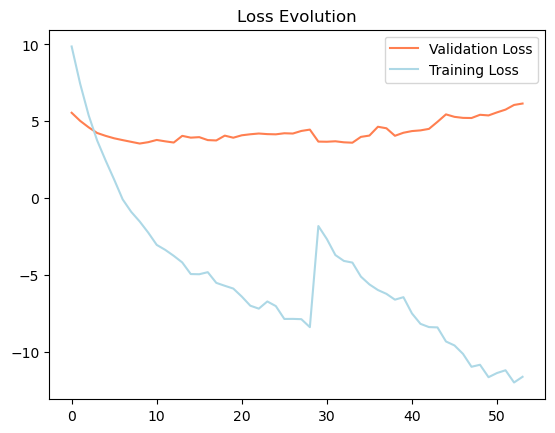

48 781 840 901 960 985
Initial sequence of 48 months, the Training   starts at: 	1944-01-01 00:00:00
                                      Validation starts at: 	2010-01-01 00:00:00
                            First Forecast at:	2020-01-01 00:00:00 valid until 	2021-01-01 00:00:00
                            Initial Sequence from:	2016-01-01 00:00:00 (912) to	2019-12-01 00:00:00 (959)
                            First IC Forecast at:	2019-12-01 00:00:00 valid until 	2020-12-01 00:00:00


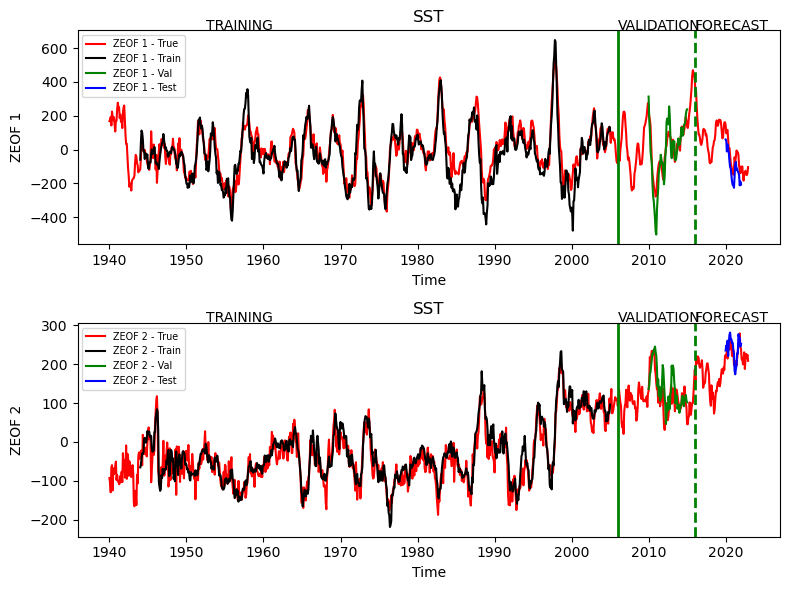

In [39]:
plt.plot(loss_va,color='coral',label='Validation Loss')
plt.plot(loss_tr,color='lightblue',label='Training Loss')
plt.legend()
plt.title('Loss Evolution')
plt.show()

times = data_time
# Plot the first subplot for the month monpred
monpred = 1

starttr = params['train_first_fcs']
endtr = params['train_last_fcs']
startval = params['val_first_fcs']
endval = params['val_last_fcs']
starttest = params['test_first_fcs']
endtest = params['test_last_fcs']
print(starttr,endtr,startval,endval,starttest,endtest)
print(f'Initial sequence of {TIN} months, the Training   starts at: \t{times[starttr]}')
print(f'                                      Validation starts at: \t{times[startval]}')
print(f'                            First Forecast at:\t{times[starttest]} valid until \t{times[starttest+Tpredict]}')
print(f'                            Initial Sequence from:\t{times[starttest-TIN]} ({starttest-TIN}) to\t{times[starttest-1]} ({starttest-1})')
print(f'                            First IC Forecast at:\t{times[starttest-1]} valid until \t{times[starttest-1+Tpredict]}')



tit ='SST'
def plot_result(ax1,out_train,out_val,out_test,monpred,neof,leof,tit,true=None):
    
    ax1.plot(times,true[:,neof], color='red', label=leof +' - True')
    ax1.plot(times[starttr:endtr],out_train[:,monpred,neof], color='black', label=leof +' - Train')
    ax1.plot(times[startval:endval],out_val[:,monpred,neof], color='green', label=leof +' - Val')
    ax1.plot(times[starttest:endtest],out_test[:,monpred,neof], color='blue', label=leof +' - Test')
    # ax1.set_xlim(times[1500],times[1600])
    ax1.set_xlabel('Time')
    ax1.set_ylabel(leof)
    ax1.set_title(tit)
    ax1.axvline(times[train_size],color='green',lw=2.0)
    ax1.axvline(times[train_size+val_size],color='green',lw=2.0,linestyle='dashed')
    _, yt = ax1.get_ylim()
    ax1.text(times[150],yt+1,'TRAINING')
    ax1.text(times[train_size],yt+1,'VALIDATION')
    ax1.text(times[train_size+val_size],yt+1,'FORECAST')
    # ax1.set_xlim((times[1500],times[1600]))
    ax1.legend(loc='upper left',fontsize='x-small')
# Create a figure with two subplots
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# plot_result(ax1,out_train_S,out_val_S,out_test_S,monpred,0,'EOF 1',tit)
# plot_result(ax2,out_train_S,out_val_S,out_test_S,monpred,1,'EOF 2',tit)

# Adjust the layout to avoid overlapping labels and titles
# plt.tight_layout()

# Display the figure
# plt.show()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
titz = tit
plot_result(ax1,out_train_p,out_val_p,out_test_p,monpred,0,'ZEOF 1',titz,true=truep)
plot_result(ax2,out_train_p,out_val_p,out_test_p,monpred,1,'ZEOF 2',titz,true=truep)

# Adjust the layout to avoid overlapping labels and titles
plt.tight_layout()

# Display the figure
plt.show()

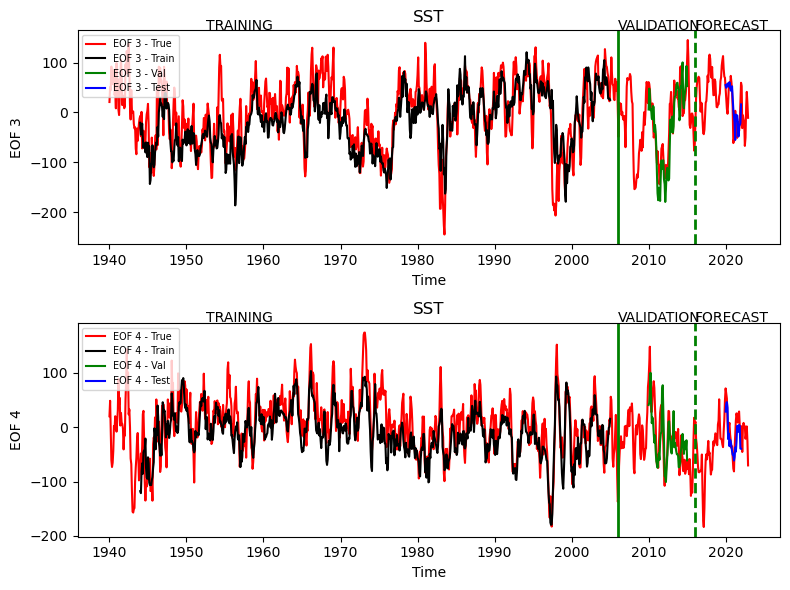

In [40]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plot_result(ax1,out_train_p,out_val_p,out_test_p,monpred,2,'EOF 3',titz,true=truep)
plot_result(ax2,out_train_p,out_val_p,out_test_p,monpred,3,'EOF 4',titz,true=truep)
# Adjust the layout to avoid overlapping labels and titles
plt.tight_layout()

# Display the figure
plt.show()


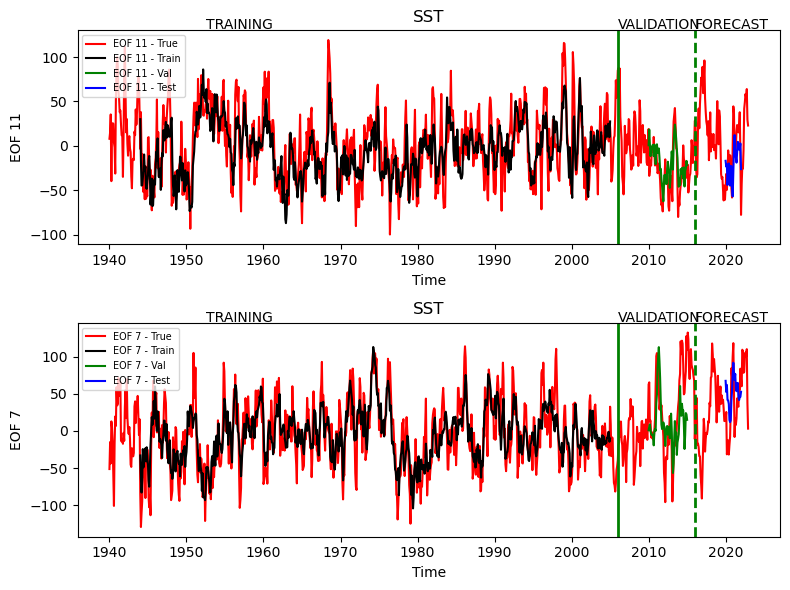

In [41]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plot_result(ax1,out_train_p,out_val_p,out_test_p,monpred,10,'EOF 11',titz,true=truep)
plot_result(ax2,out_train_p,out_val_p,out_test_p,monpred,6,'EOF 7',titz,true=truep)
# Adjust the layout to avoid overlapping labels and titles
plt.tight_layout()

# Display the figure
plt.show()


In [42]:
# Create arrays of ordered forecasts and verification fields

# F, V, P, Obs = zai.eof_to_grid('test','SSTSST', truep, out_test_p, times, INX=PDX, params=params, truncation=None)



In [43]:
Cont = namedtuple('Contours', 'max min int')
cont_ = Cont(4, -3, 0.5)
cont_

Contours(max=4, min=-3, int=0.5)

In [44]:
# cont = [-3, 3, 0.25]

plfield='SSTSST'
arealatz = zai.select_field_key(INX,plfield,'arealat')
arealonz = zai.select_field_key(INX,plfield,'arealon')
# utp.many_plots(V,'T2M', 'T2M', cont, '2021-01-01', mode='lead',title='', mainlabel='Verification ',lead=0,nrows=3,ncols=2, arealatz=arealatz, arealonz=arealonz,  centlon=PDX[plfield]['centlon'],labfile='Test1.pdf')
# utp.many_plots(F,'T2M', 'T2M', cont, '2021-01-01', mode='time',title='',mainlabel='Forecasts ', lead=1,nrows=3,ncols=2, arealatz=arealatz, arealonz=arealonz, centlon=PDX[plfield]['centlon'],labfile='Test2.pdf')
    

In [45]:
F, V, P, Obs = zai.eof_to_grid_new('test','SSTSST', truep, out_test_p, times, INX=PDX, params=params, truncation=None)

Verification using entire field (298511, 996))
Persistence using entire field (298511, 996)
Obs from 1940-01-01T00:00:00.000000000 to 2022-12-01T00:00:00.000000000

 Number of cases 25
Observation selected for test 
 
Obs from 2020-01-01T00:00:00.000000000 to 2022-02-01T00:00:00.000000000

Verification for first forecast at 960 to 985
Verification time for `test` from first month forecast 2020-01-01T00:00:00.000000000 to 2022-02-01T00:00:00.000000000
Tmp shape (25, 13, 298511), 2019-12-01T00:00:00.000000000 to 2021-12-01T00:00:00.000000000
Verification shape (25, 13, 298511), 2019-12-01T00:00:00.000000000 to 2021-12-01T00:00:00.000000000
Forecast shape (25, 13, 298511), 2019-12-01T00:00:00.000000000 to 2021-12-01T00:00:00.000000000
Persistence shape (25, 13, 298511), 2019-12-01T00:00:00.000000000 to 2021-12-01T00:00:00.000000000


In [46]:
# check if the starting date is within the limit of the dynamicalforecasts
# Always use the best overlap period
dyn_startdate = pd.Timestamp('2018-11-01')
dyn_enddate = times[endtest+Tpredict-2]

if times[starttest] > dyn_startdate:
    dyn_startdate = times[starttest]
    
print(f'Dynamical forecasts from {dyn_startdate} to {dyn_enddate}')
print(f'Forecasts from {times[starttest]} to {times[endtest]}')

Dynamical forecasts from 2020-01-01 00:00:00 to 2022-12-01 00:00:00
Forecasts from 2020-01-01 00:00:00 to 2022-02-01 00:00:00


In [47]:
# Read dynamical forecast and compute correlations
# Forecast for different lead times have dates that correspond to the verification time.
endindex=np.where(times == dyn_enddate)
startindex = np.where(times == dyn_startdate)

dyn_cmcc = {'center':'cmcc','system':['3','35'], 'SST':'SST', 'T2M':'2t','startdate':dyn_startdate.strftime('%Y-%m-%d'),'enddate':'2022-05-01'}

dyn_cases = [dyn_cmcc]

ver_f = INX[plfield]['field'].upper()
ndyn = int(endindex[0]-startindex[0]+1)
ngrid = INX[plfield]['X'].A.shape[0]
dynddr =  homedir + drop_home + '/ERA5/SEASONAL_'+ ver_f

filever = 'DYN_' + ver_f + params['savefile']   + '.nc'

if verify_dyn:
    DYN = zai.make_dyn_verification(ver_f,INX[plfield]['area'], dyn_cases, dynddr, times, dyn_startdate,dyn_enddate, filever)

Starting date for verification of dynamic data 2020-01-01 00:00:00 and ending date 2022-12-01 00:00:00
Number of months for verification 36
Verification field SST
Verification data not found -- Creating file DYN_SSTinformer_X620_anom_1_512_48_False.nc
0 0 /Users/antonionavarra/CMCC Dropbox/Antonio Navarra/ERA5/SEASONAL_SST/SST_cmcc_3_1.nc
Variable selected ---> ssta, size (9, 721, 1440)
Use Pacific centered coordinates with centlat=180
0 1 /Users/antonionavarra/CMCC Dropbox/Antonio Navarra/ERA5/SEASONAL_SST/SST_cmcc_35_1.nc
Variable selected ---> ssta, size (21, 721, 1440)
Use Pacific centered coordinates with centlat=180
AT lead 0, Result shape (30, 404640), times 2020-01-01T00:00:00.000000000 to 2022-06-01T00:00:00.000000000
(30, 6, 404640) (30, 404640)
1 0 /Users/antonionavarra/CMCC Dropbox/Antonio Navarra/ERA5/SEASONAL_SST/SST_cmcc_3_2.nc
Variable selected ---> ssta, size (9, 721, 1440)
Use Pacific centered coordinates with centlat=180
1 1 /Users/antonionavarra/CMCC Dropbox/Antonio

In [48]:
# Coompute arrays for dynamical model verification
if verify_dyn:
    SD = DYN
    # Stack and restack to get the NaN as the dynamics files
    VD = V.sel(time=slice(dyn_startdate,'2022-05-01')).unstack().stack(z=("lat", "lon"))


In [49]:
if write_result:
    # Write forecast and verification
    case_data =  xr.Dataset({'F': F,'V': V,'P':P, 'SD':SD,'VD':VD})
    filedyn = f"RES_{params['savefile']}.nc"

    import cf_xarray as cfxr
    xr.set_options(keep_attrs=True)
    cfxr.encode_multi_index_as_compress(case_data, 'z').to_netcdf(filedyn)

In [50]:
# Add Initial conditions to the dynamical forecasts
IC = V[:,0,:].expand_dims('lead',axis=1)
NEW_DYN = xr.concat([IC,DYN],dim='lead')


Plotting for time 2021-06-01T00:00:00.000000000 a total of 6 time steps
 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25


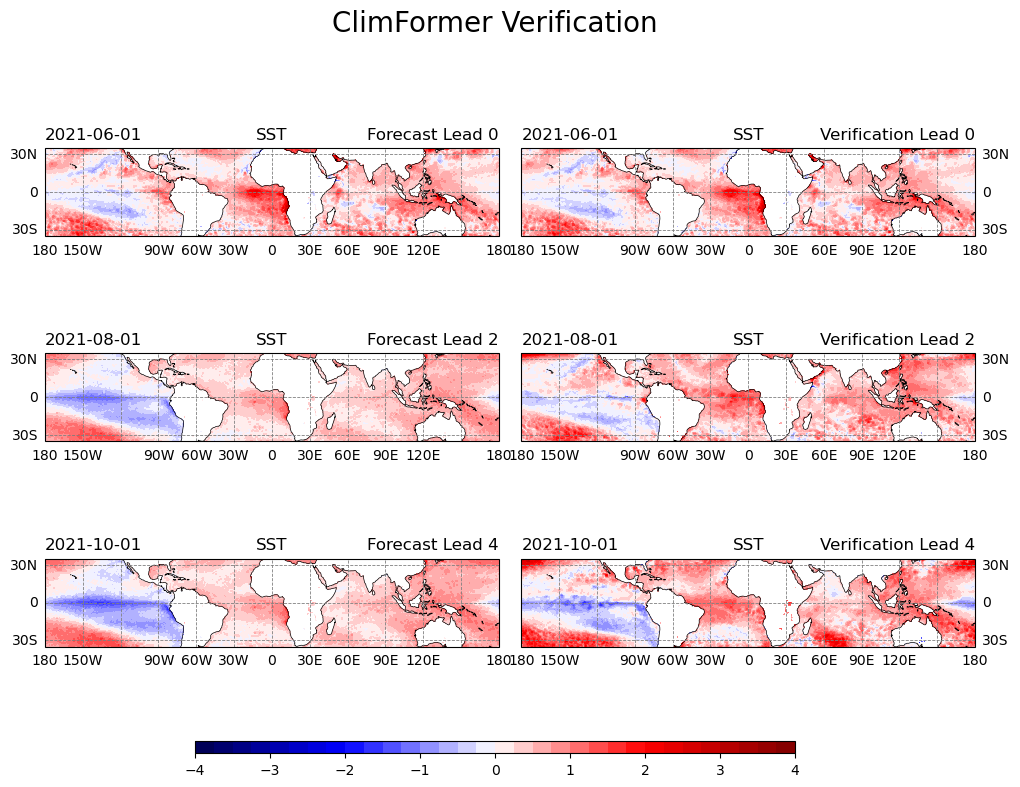

In [51]:

Cont = namedtuple('Contours', 'max min int')
cont_ = Cont(4, -4, 0.25)
np.arange(cont_.min,cont_.max,cont_.int)
cont=[cont_.min, cont_.max, cont_.int]

# cont = []
if Tpredict > 5:
    utp.Single_Forecast_plots(F, V,  'SST', None, cont, '2021-07-01', maxtime=6, stride=2, title='ClimFormer Verification', colorbars=False, mainlabel='', arealatz=arealatz, arealonz=arealonz, centlon=PDX[plfield]['centlon'],labfile='Fcst.pdf')


Plotting for time 2021-06-01T00:00:00.000000000 a total of 6 time steps
 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25


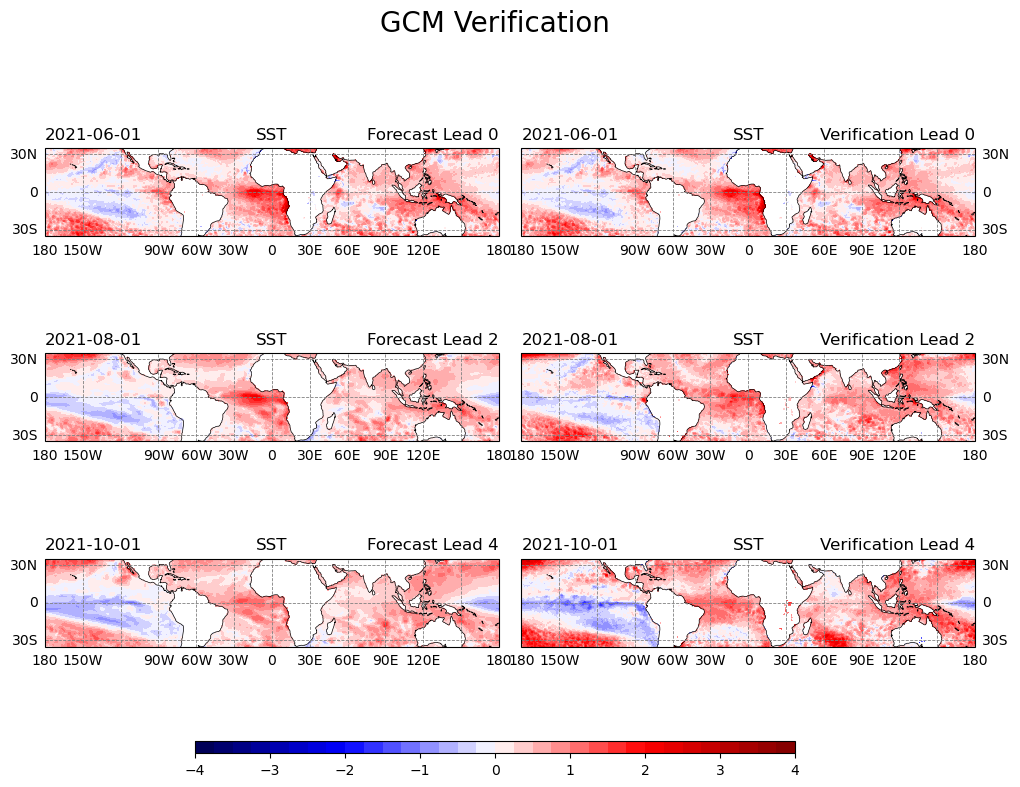

In [52]:
utp.Single_Forecast_plots(NEW_DYN, V,  'SST', None, cont, '2021-07-01', maxtime=6, stride=2, title='GCM Verification', colorbars=False, mainlabel='', arealatz=arealatz, arealonz=arealonz, centlon=PDX[plfield]['centlon'],labfile='FcstTrunc.pdf')


In [53]:
# Compute correlation for dynamical model
# For each day
    
if verify_dyn:
    ERROR = 'L2'
    Tpredict_dyn = 7

    corrdyn = np.zeros((Tpredict_dyn-1,SD.shape[0]))
    rmsdyn = np.zeros((Tpredict_dyn-1,SD.shape[0]))

    totday,totfor = corrdyn.shape
    print(SD.shape,VD.shape,corrdyn.shape)
    # The number of forecast for the dynamical list is limited to 7 months, so the number of cases must be reduced.
    number_of_dyn = VD.shape[0]

    for icj in range(totday): 
            print(f'Treating Day ---> {icj}')
            corrdyn[icj,:number_of_dyn] = xr.corr(SD[:number_of_dyn,icj,:],VD[:,icj,:], dim='z').data   
            NumPoints = F.shape[2]
            if ERROR == 'L1':
                rmsdyn[icj,:number_of_dyn]= np.sum(abs(SD[:number_of_dyn,icj,:] - VD[:,icj,:]),axis=1).data/NumPoints
            else:
                rmsdyn[icj,:number_of_dyn]= np.sqrt(np.sum((SD[:number_of_dyn,icj,:] - VD[:,icj,:])**2,axis=1).data)/NumPoints


(30, 6, 404640) (24, 13, 404640) (6, 30)
Treating Day ---> 0
Treating Day ---> 1
Treating Day ---> 2
Treating Day ---> 3
Treating Day ---> 4
Treating Day ---> 5


In [54]:
Titolo = namedtuple('Titolo', 'maintitle lefttitle righttitle')
a = Titolo('SST','Exp1','EOF1')
a.maintitle

'SST'

In [55]:
# Compute correlation
# For each day

ERROR = 'L2'
Np, _, _ = F.shape

corrresult = np.zeros((Tpredict+1,Np))
persistence = np.zeros((Tpredict+1,Np))

rmsres = np.zeros((Tpredict+1,Np))
rmsper = np.zeros((Tpredict+1,Np))

# totday,totfor = corrresult.shape

ictime = Obs.time
starttest = params['test_period_start'] 

for iday in range(Tpredict+1):
    this_day = ictime[starttest+1+iday:starttest+iday+Np+1]
    Fp = F[:,iday,:].assign_coords({'time':this_day.data})
    Vp = V[:,iday,:].assign_coords({'time':this_day.data})
    Pp = P[:,iday,:].assign_coords({'time':this_day.data})
    corrresult[iday,:]= xr.corr(Fp,Vp, dim='z').data
    persistence[iday,:]= xr.corr(Pp,Vp, dim='z').data
    if verify_dyn:
        dyn = np.mean(corrdyn,axis=1)  # Start from month 1
    
    NumPoints = F.shape[2]
    if ERROR == 'L1':
        rmsresi[iday,:]= np.sum(abs(Fp - Vp),axis=2).data/NumPoints
        rmsper[iday,:]= np.sum(abs(Pp - Vp),axis=2).data/NumPoints
    else:
        rmsres[iday,:]= np.sqrt(np.sum((Fp - Vp)**2,axis=1).data)/NumPoints
        rmsper[iday,:]= np.sqrt(np.sum((Pp - Vp)**2,axis=1).data)/NumPoints


In [56]:
# 
plfield = 'SSTSST'
starttest = params['test_period_start']  + TIN
endtest = starttest + Np - 1

figarea = INX[plfield]['area']
figinfield = [i for i in INX.keys()]
idfig = f"FIELDS={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['FFN_DIM']},H={params['ENC_Heads']},LY={params['enc_dec_layers']}"

# fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(8, 8))

# for i in range(1,Tpredict,5):
#     hl, = ax1.plot(times[starttest:endtest+1],corrresult[i,:],label=f'Month {i}')
#     ax1.plot(times[starttest:endtest+1],persistence[i,:],label=f'Pers {i}',linestyle='dashed',color=hl.get_color())
# ax1.set_ylim(-0.4,1.2)
# ax1.set_title(f'Skill Score {plfield} in {figarea}',loc='left')
# ax1.set_title(idfig,loc='right',fontsize=8)

# ax1.legend()

    
# tw = [sum(np.where(corrresult[i,:] > 0.6, 1,0))/Np for i in range(Tpredict)]
# ax3.bar(np.arange(1,Tpredict+1),tw)
# ax3.set_title('Number of forecasts above 0.6')
# ax3.set_xlabel('Lead Months')
# # plt.savefig('Bar'+idfig+'.pdf')
# plt.show()

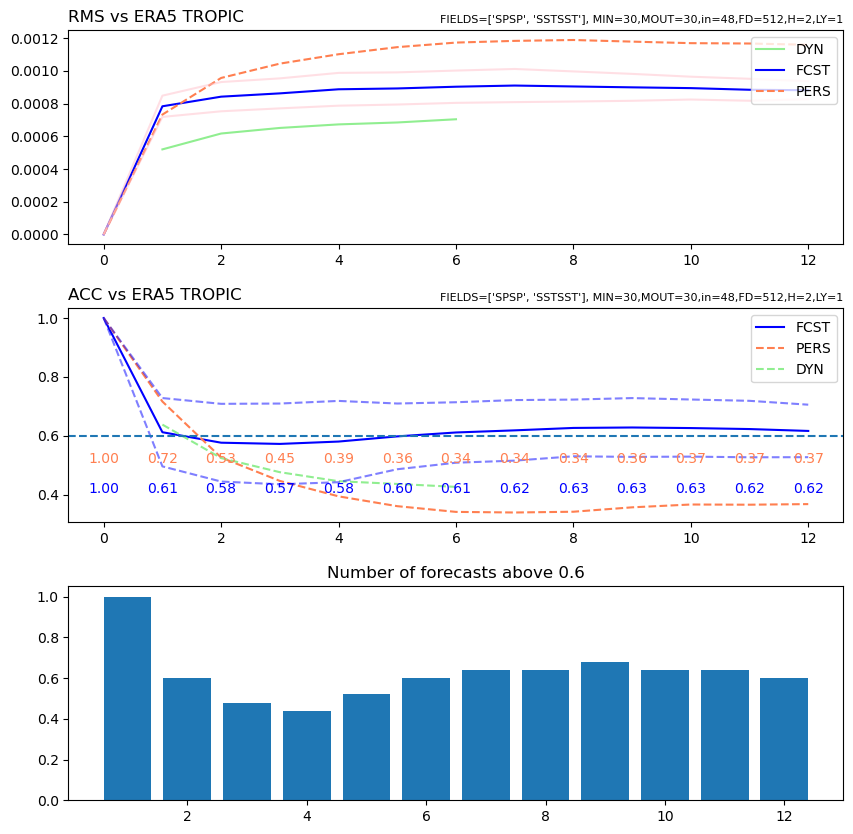

In [57]:
# Mean
# Create a figure with GridSpec layout
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(3, 1, width_ratios=[0.5], height_ratios=3*[1], wspace=0.3, hspace=0.3)

# Left panels
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])



sk = np.mean(corrresult,axis=1)
skstd = np.std(corrresult,axis=1)
ps = np.mean(persistence,axis=1)

if verify_dyn:
    dyn = np.mean(corrdyn,axis=1)  # Start from month 1
    dystd = np.std(corrdyn,axis=1)

tim = np.arange(0,Tpredict+1)
# print(tim.shape,sk.shape)
ax2.plot(tim, sk,label='FCST',color='blue')
ax2.plot(tim, ps,linestyle='dashed',color='coral',label='PERS')
if verify_dyn:
    ax2.plot(tim[1:7], dyn,linestyle='dashed',color='lightgreen',label='DYN')

ax2.plot(tim,sk+skstd,color='blue',alpha=0.5,linestyle='dashed')
ax2.plot(tim,sk-skstd,color='blue',alpha=0.5,linestyle='dashed')
# ax2.plot(tim[:-1],(dyn+dystd)[1:],color='lightgreen',alpha=0.5)
# ax2.plot(tim[:-1],(dyn-dystd)[1:],color='lightgreen',alpha=0.5)


ax2.axhline(0.6,linestyle='dashed')
ax2.set_title(f'ACC vs ERA5 {figarea}',loc='left')
ax2.set_title(idfig,loc='right',fontsize=8)
for ii in range(0,Tpredict+1):
    ax2.text(ii,min(ax2.get_ylim())+0.1,f'{sk[ii]:4.2f}',horizontalalignment='center',color='blue')
    ax2.text(ii,min(ax2.get_ylim())+0.2,f'{ps[ii]:4.2f}',horizontalalignment='center',color='coral')
ax2.legend(loc='upper right')
# ax2.set_xlim(1,7)    

sk = np.mean(rmsres,axis=1)
skstd = np.std(rmsres,axis=1)
ps = np.mean(rmsper,axis=1)



if verify_dyn:
    rdyn = np.mean(rmsdyn,axis=1)
    ax1.plot(tim[1:7], rdyn,label='DYN',color='lightgreen')
ax1.plot(tim, sk,label='FCST',color='blue')
ax1.plot(tim,ps,linestyle='dashed',color='coral',label='PERS')

ax1.plot(tim,sk+skstd,color='pink',alpha=0.5)
ax1.plot(tim,sk-skstd,color='pink',alpha=0.5)

ax1.set_title(f'RMS vs ERA5 {figarea}',loc='left')
ax1.set_title(idfig,loc='right',fontsize=8)

ax1.legend(loc='upper right')

tw = [sum(np.where(corrresult[i,:] > 0.6, 1,0))/Np for i in range(Tpredict)]
ax3.bar(np.arange(1,Tpredict+1),tw)
ax3.set_title('Number of forecasts above 0.6')

# plt.savefig('Skill'+idfig +'.pdf')
plt.show()

In [58]:
skill = 'median' #'mean'

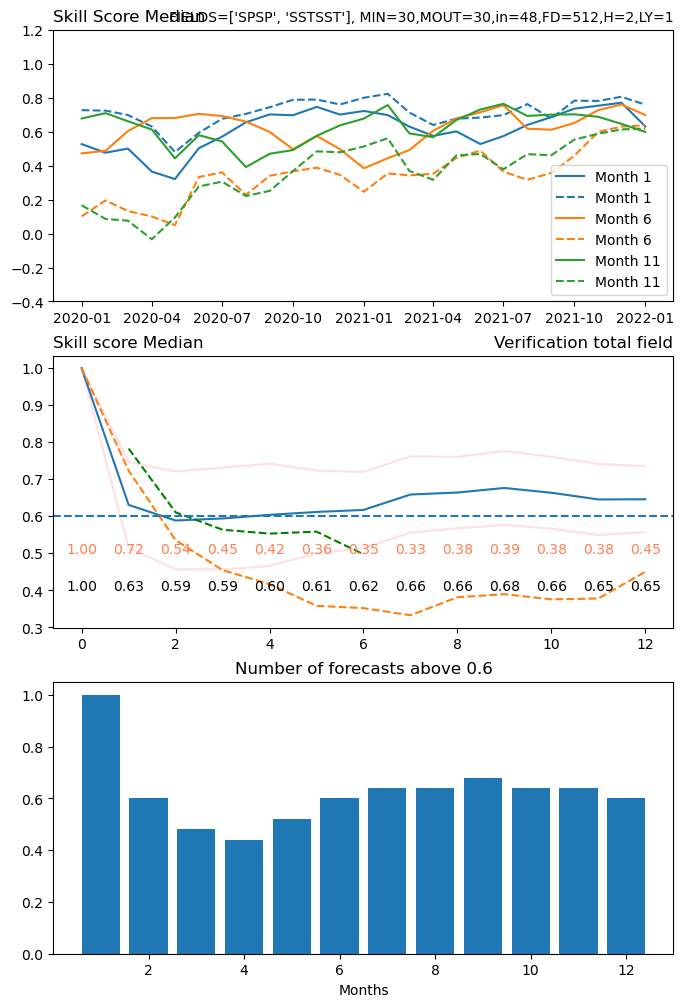

In [59]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(8, 12))

for i in range(1,Tpredict,5):
    hl,=ax1.plot(times[starttest:endtest+1],corrresult[i,:],label=f'Month {i}')
    ax1.plot(times[starttest:endtest+1],persistence[i,:],label=f'Month {i}',color=hl.get_color(), linestyle='dashed')
idfig = f"FIELDS={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['FFN_DIM']},H={params['ENC_Heads']},LY={params['enc_dec_layers']}"
    
ax1.set_ylim(-0.4,1.2)
ax1.set_title('Skill Score Median',loc='left')
ax1.set_title(idfig,loc='right',fontsize=10)
ax1.legend()

tim = np.arange(0,Tpredict+1)

match skill:
    case 'mean':
        sk = np.mean(corrresult,axis=1)
        ps = np.mean(persistence,axis=1)
        if verify_dyn:
            dyn = np.mean(corrdyn,axis=1)  # Start from month 1
        ax2.plot(tim,corrresult.mean(axis=1)+corrresult.std(axis=1),color='pink',alpha=0.5)
        ax2.plot(tim,corrresult.mean(axis=1)-corrresult.std(axis=1),color='pink',alpha=0.5)
    case 'median':
        sk = np.median(corrresult,axis=1)
        ps = np.median(persistence,axis=1)
        if verify_dyn:
            dyn = np.median(corrdyn,axis=1)  # Start from month 1
        ax2.plot(tim,np.median(corrresult,axis=1)+corrresult.std(axis=1),color='pink',alpha=0.5)
        ax2.plot(tim,np.median(corrresult,axis=1)-corrresult.std(axis=1),color='pink',alpha=0.5)
    case _:
        raise ValueError('Invalid skill choice')
ax2.plot(tim,sk)
ax2.plot(tim,ps,linestyle='dashed')
if verify_dyn:
    ax2.plot(tim[1:7],dyn,linestyle='dashed',color='green')
        
ax2.axhline(0.6,linestyle='dashed')
ax2.set_title('Skill score Median',loc='left')
ax2.set_title('Verification total field',loc='right')
for ii in range(0,Tpredict+1):
    ax2.text(ii,min(ax2.get_ylim())+0.1,f'{sk[ii]:4.2f}',horizontalalignment='center')
    ax2.text(ii,min(ax2.get_ylim())+0.2,f'{ps[ii]:4.2f}',horizontalalignment='center',color='coral')
    
tw = [sum(np.where(corrresult[i,:] > 0.6, 1,0))/Np for i in range(Tpredict)]
ax3.bar(np.arange(1,Tpredict+1),tw)
ax3.set_title('Number of forecasts above 0.6')
ax3.set_xlabel('Months')
plt.savefig(f'FIG_{file}_{skill}.pdf')
plt.show()

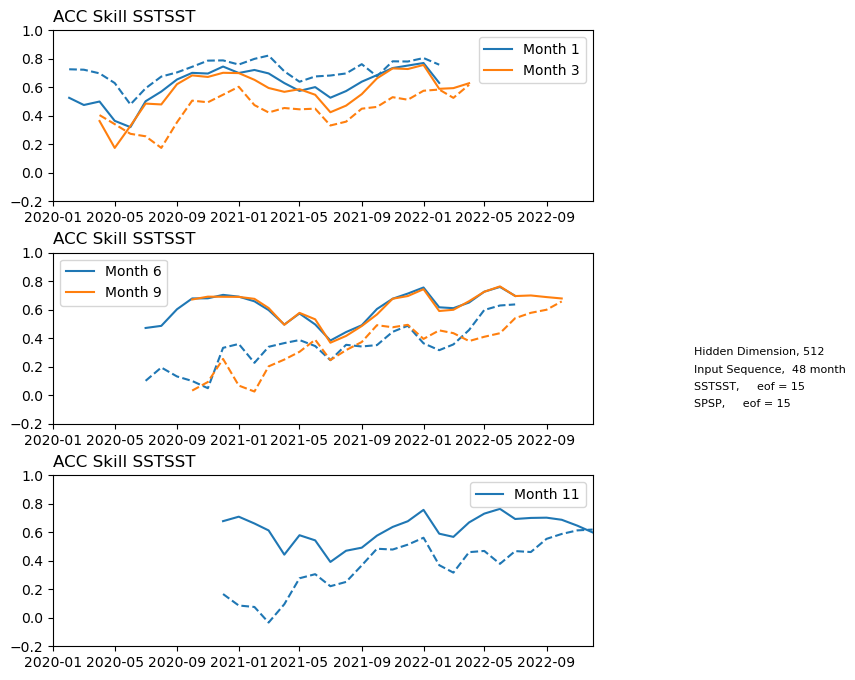

In [60]:
#Figure for forecast

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(3, 2, width_ratios=[4, 1], height_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)

# Left panels
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

# Right panel, aligned with the middle left panel
ax4 = fig.add_subplot(gs[1, 1])

tit = f'ACC Skill {plfield}'
if_time = [1,3]
col = ['black','red','lightblue', 'blue','green']

for i in if_time:
    hl,=ax1.plot(times[starttest+i:endtest+1+i],corrresult[i,:],label=f'Month {i}')
    ax1.plot(times[starttest+i:endtest+1+i],persistence[i,:],color=hl.get_color(), linestyle='dashed')

ax1.set_xlim(times[starttest], times[endtest+Tpredict-1])
ax1.set_ylim(-0.2,1.0)
ax1.set_title(tit,loc='left')
# ax1.set_title(idfig,loc='right',fontsize=10)
ax1.legend()

if_time = [6,9]
for i in if_time:
    hl,=ax2.plot(times[starttest+i:endtest+1+i],corrresult[i,:],label=f'Month {i}')
    ax2.plot(times[starttest+i:endtest+1+i],persistence[i,:],color=hl.get_color(), linestyle='dashed')

ax2.set_xlim(times[starttest], times[endtest+Tpredict-1])
ax2.set_ylim(-0.2,1.0)
ax2.set_title(tit,loc='left')
# ax2.set_title(idfig,loc='right',fontsize=10)
ax2.legend()

if_time = [11]
for i in if_time:
    hl,=ax3.plot(times[starttest+i:endtest+1+i],corrresult[i,:],label=f'Month {i}')
    ax3.plot(times[starttest+i:endtest+1+i],persistence[i,:],color=hl.get_color(), linestyle='dashed')

ax3.set_xlim(times[starttest], times[endtest+Tpredict-1])
ax3.set_ylim(-0.2,1.0)
ax3.set_title(tit,loc='left')
# ax3.set_title(idfig,loc='right',fontsize=10)
ax3.legend()

# Remove the axis and labels for ax4
ax4.axis('off')  # This removes the axis lines and ticks
ax4.set_xticklabels([])  # This removes the x-axis labels
ax4.set_yticklabels([])  # This removes the y-axis labels

# Label the experiment
dfig = f"Predictors={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['FFN_DIM']},H={params['ENC_Heads']},LY={params['enc_dec_layers']}"
delta = 0.0
ffcol = {'fontsize':8, 'color':'black'}
for ff in INX.keys():
    lab = f"{ff},     eof = {INX[ff]['mr']}"
    ax4.text(0, 0.1+delta, lab, **ffcol) 
    delta += 0.1
ax4.text(0, 0.3, f'Input Sequence,  {TIN} month', **ffcol) 
ax4.text(0, 0.4, f"Hidden Dimension, {params['FFN_DIM']}", **ffcol) 

# Adjust layout
plt.tight_layout()
plt.show()

# Figure for paper

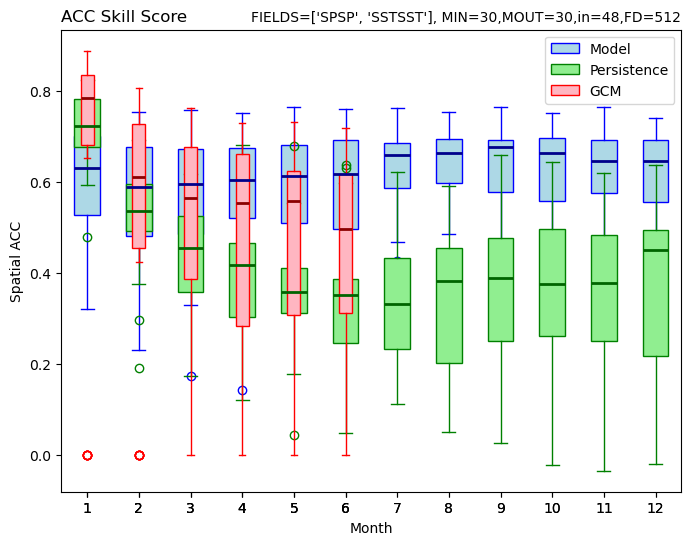

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data
np.random.seed(10)
data = [np.random.normal(0, std, 100) for std in range(1, 4)]

# Create a box plot with customization
plt.figure(figsize=(8, 6))
# box = plt.boxplot(corrresult.T, vert=True, patch_artist=True, notch=False, widths=0.2)
# box1 = plt.boxplot(persistence.T, vert=True, patch_artist=True, notch=False, widths=0.2)

#Customizing box plot appearance

# Create a box plot with different colors for each dataset
box1 = plt.boxplot(corrresult[1:,:].T, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', color='blue'),
                  medianprops=dict(color='darkblue',linewidth=2),
                  whiskerprops=dict(color='blue'),
                  capprops=dict(color='blue'),
                  flierprops=dict(markeredgecolor='blue'),
                  )
box2 = plt.boxplot(persistence[1:,:].T, patch_artist=True,
                  boxprops=dict(facecolor='lightgreen', color='green'),
                  medianprops=dict(color='darkgreen',linewidth=2),
                  whiskerprops=dict(color='green'),
                  capprops=dict(color='green'),
                  flierprops=dict(markeredgecolor='green'),
                  )


if verify_dyn:
    box3 = plt.boxplot(corrdyn.T, patch_artist=True, widths=0.25,
                  boxprops=dict(facecolor='lightpink', color='red'),
                  medianprops=dict(color='darkred',linewidth=2),
                  whiskerprops=dict(color='red'),
                  capprops=dict(color='red'),
                  flierprops=dict(markeredgecolor='red'),
                  )

# Add a legend
plt.legend([box1["boxes"][0], box2["boxes"][0],box3["boxes"][0]], ['Model', 'Persistence','GCM'], loc='upper right')

# Add title and labels
plt.title('ACC Skill Score',loc='left')
plt.title(idfig,loc='right',fontsize=10)
plt.xlabel('Month')
plt.ylabel('Spatial ACC')

# Show the plot
plt.savefig(f'FIG_{file}_Box.pdf')
plt.show()

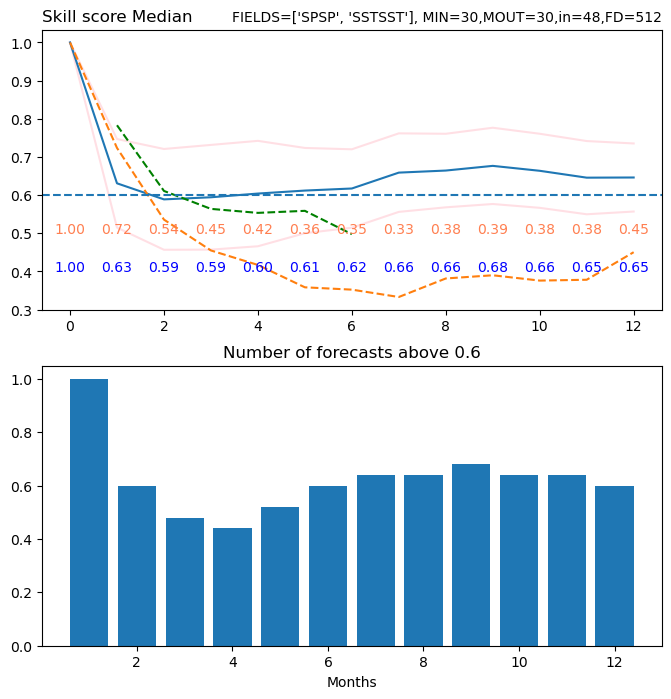

In [63]:


fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(8, 8))

# for i in range(1,Tpredict,5):
#     hl,=ax1.plot(times[starttest:endtest+1],corrresult[i,:],label=f'Month {i}')
#     ax1.plot(times[starttest:endtest+1],persistence[i,:],label=f'Month {i}',color=hl.get_color(), linestyle='dashed')
idfig = f"FIELDS={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['FFN_DIM']}"
    
# ax1.set_ylim(-0.4,1.2)
# ax1.set_title('Skill Score Median',loc='left')
# ax1.set_title(idfig,loc='right',fontsize=10)
# ax1.legend()
skill='median'

tim = np.arange(0,Tpredict+1)

match skill:
    case 'mean':
        sk = np.mean(corrresult,axis=1)
        ps = np.mean(persistence,axis=1)
        if verify_dyn:
            dyn = np.mean(corrdyn,axis=1)  # Start from month 1
        ax2.plot(tim,corrresult.mean(axis=1)+corrresult.std(axis=1),color='pink',alpha=0.5)
        ax2.plot(tim,corrresult.mean(axis=1)-corrresult.std(axis=1),color='pink',alpha=0.5)
    case 'median':
        sk = np.median(corrresult,axis=1)
        ps = np.median(persistence,axis=1)
        if verify_dyn:
            dyn = np.median(corrdyn,axis=1)  # Start from month 1
        ax2.plot(tim,np.median(corrresult,axis=1)+corrresult.std(axis=1),color='pink',alpha=0.5)
        ax2.plot(tim,np.median(corrresult,axis=1)-corrresult.std(axis=1),color='pink',alpha=0.5)
    case _:
        raise ValueError('Invalid skill choice')
ax2.plot(tim,sk)
ax2.plot(tim,ps,linestyle='dashed')
if verify_dyn:
    ax2.plot(tim[1:7],dyn,linestyle='dashed',color='green')
        
ax2.axhline(0.6,linestyle='dashed')
ax2.set_title('Skill score Median',loc='left')
ax2.set_title(idfig,loc='right',fontsize=10)
for ii in range(0,Tpredict+1):
    ax2.text(ii,min(ax2.get_ylim())+0.1,f'{sk[ii]:4.2f}',horizontalalignment='center',color='blue')
    ax2.text(ii,min(ax2.get_ylim())+0.2,f'{ps[ii]:4.2f}',horizontalalignment='center',color='coral')
    
tw = [sum(np.where(corrresult[i,:] > 0.6, 1,0))/Np for i in range(Tpredict)]
ax3.bar(np.arange(1,Tpredict+1),tw)
ax3.set_title('Number of forecasts above 0.6')
ax3.set_xlabel('Months')
plt.savefig(f'FIG_{file}_{skill}.pdf')
plt.show()

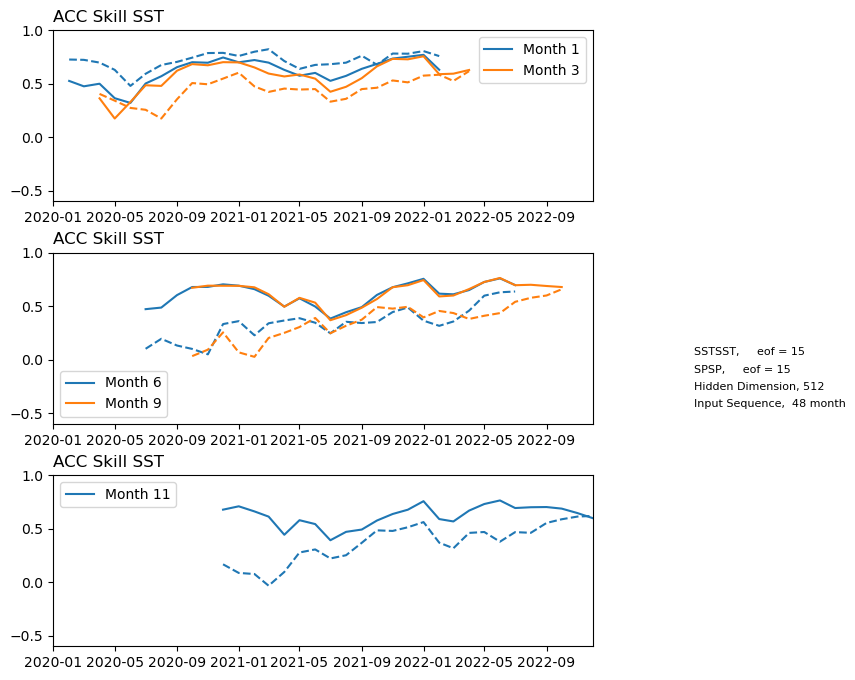

In [64]:
#Figure for forecast

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(3, 2, width_ratios=[4, 1], height_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)

# Left panels
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

# Right panel, aligned with the middle left panel
ax4 = fig.add_subplot(gs[1, 1])

tit = f'ACC Skill {plfield[0:3]}'
if_time = [1,3]
col = ['black','red','lightblue', 'blue','green']

# GCM Dates
date_range = pd.date_range(start='2019-01-01', end='2022-05-01',freq='M')
gcm_index_start = times.get_loc('2019-01-01')
gcm_index_end = times.get_loc('2022-06-01')

for i in if_time:
    hl,=ax1.plot(times[starttest+i:endtest+1+i],corrresult[i,:],label=f'Month {i}')
    ax1.plot(times[starttest+i:endtest+1+i],persistence[i,:],color=hl.get_color(), linestyle='dashed')
    # ax1.plot(times[gcm_index_start+i:gcm_index_end+1+i],corrdyn[i,:],color='green', linestyle='dashed')

ax1.set_xlim(times[starttest], times[endtest+Tpredict-1])
ax1.set_ylim(-0.6,1.0)
ax1.set_title(tit,loc='left')
# ax1.set_title(idfig,loc='right',fontsize=10)
ax1.legend()

if_time = [6,9]
for i in if_time:
    hl,=ax2.plot(times[starttest+i:endtest+1+i],corrresult[i,:],label=f'Month {i}')
    ax2.plot(times[starttest+i:endtest+1+i],persistence[i,:],color=hl.get_color(), linestyle='dashed')

ax2.set_xlim(times[starttest], times[endtest+Tpredict-1])
ax2.set_ylim(-0.6,1.0)
ax2.set_title(tit,loc='left')
# ax2.set_title(idfig,loc='right',fontsize=10)
ax2.legend()

if_time = [11]
for i in if_time:
    hl,=ax3.plot(times[starttest+i:endtest+1+i],corrresult[i,:],label=f'Month {i}')
    ax3.plot(times[starttest+i:endtest+1+i],persistence[i,:],color=hl.get_color(), linestyle='dashed')

ax3.set_xlim(times[starttest], times[endtest+Tpredict-1])
ax3.set_ylim(-0.6,1.0)
ax3.set_title(tit,loc='left')
# ax3.set_title(idfig,loc='right',fontsize=10)
ax3.legend()

# Remove the axis and labels for ax4
ax4.axis('off')  # This removes the axis lines and ticks
ax4.set_xticklabels([])  # This removes the x-axis labels
ax4.set_yticklabels([])  # This removes the y-axis labels

# Label the experiment
dfig = f"Predictors={figinfield}, MIN={MIN},MOUT={K},in={TIN},FD={params['FFN_DIM']},H={params['ENC_Heads']},LY={params['enc_dec_layers']}"
delta = 0.0
ffcol = {'fontsize':8, 'color':'black'}

ax4.text(0, 0.1, f'Input Sequence,  {TIN} month', **ffcol) 
ax4.text(0, 0.2, f"Hidden Dimension, {params['FFN_DIM']}", **ffcol) 
for ff in INX.keys():
    lab = f"{ff},     eof = {INX[ff]['mr']}"
    ax4.text(0, 0.3+delta, lab, **ffcol) 
    delta += 0.1
    
    
# Adjust layout
plt.tight_layout()
plt.savefig(f'FIG_{file}_Month.pdf')
plt.show()

Plotting for time 2020-11-01T00:00:00.000000000 a total of 3 lead times
dynamic time 7
 Opening figure , 3 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
No GCM data for lead 11


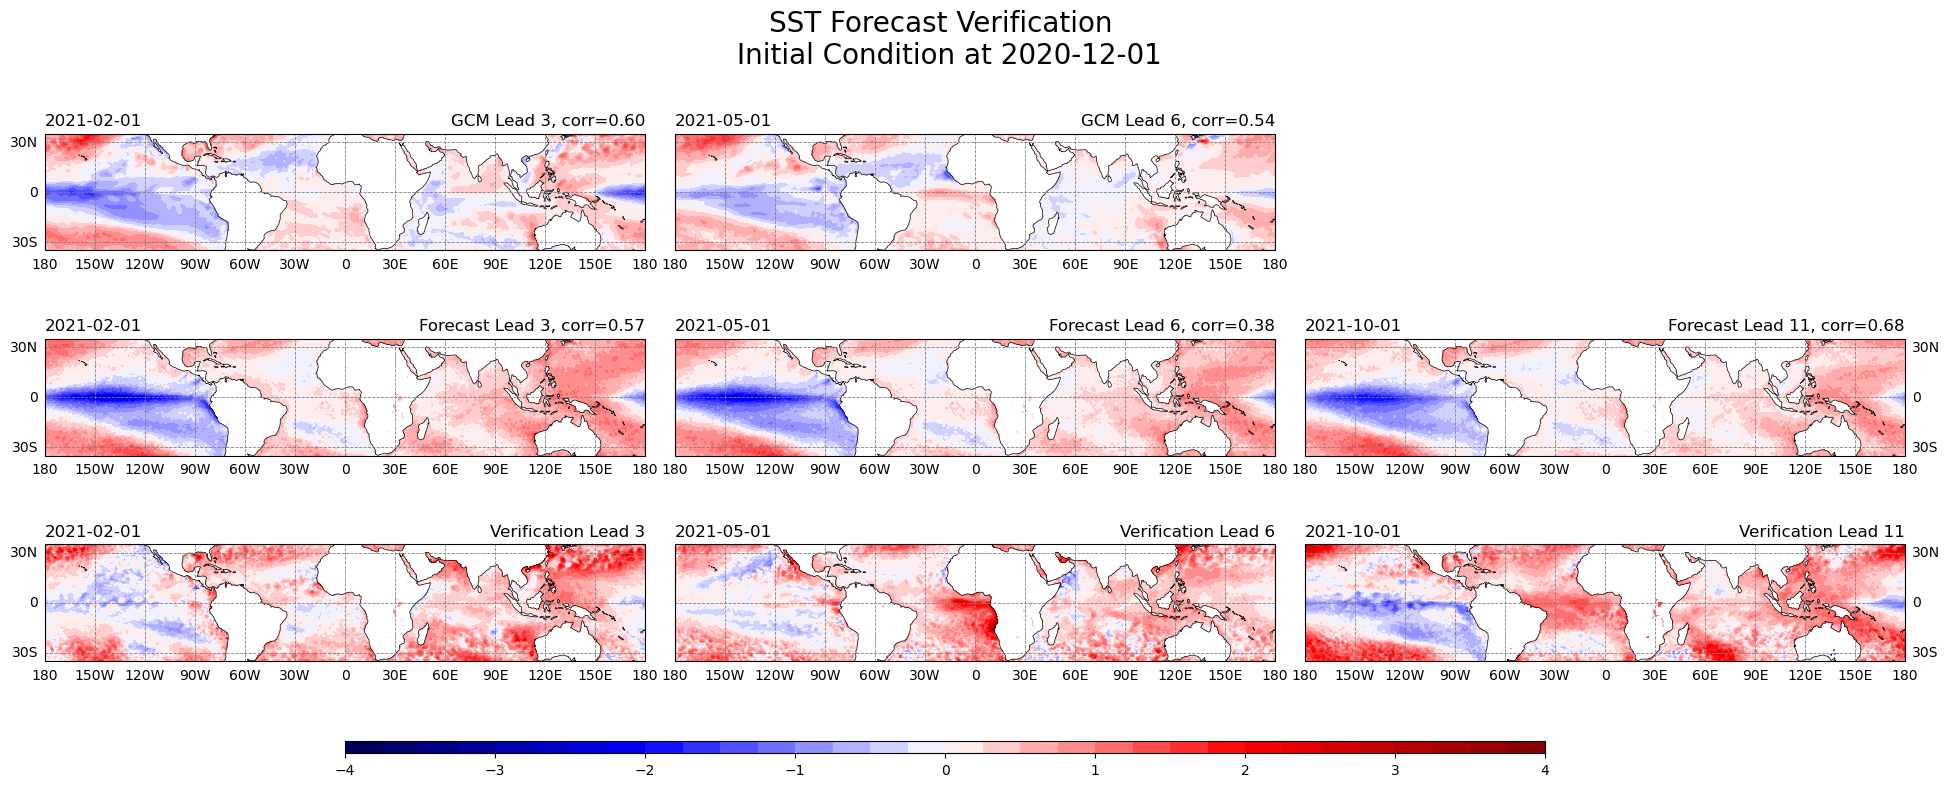

In [65]:
# Worst Forecast
cday = 6
im = np.argmin(corrresult[cday,:])
im, corrresult[cday,im]

Cont = namedtuple('Contours', 'max min int')
cont_ = Cont(4, -4, 0.25)
np.arange(cont_.min,cont_.max,cont_.int)
cont=[cont_.min, cont_.max, cont_.int]
this_forecast = str(F.time.isel(time=im).data[()]).split('T')[0]

# Correlation for the pictures
loc_dyn = np.concatenate((np.ones((1, corrdyn.shape[1])), corrdyn), axis=0)
leads = [3,6,11]
labels_forecast = [f'corr={corrresult[i,im]:.2f}' for i in leads]
labels_GCM = [f'corr={loc_dyn[i, im]:.2f}' for i in leads if i < 7]


tit = f'SST Forecast Verification \n Initial Condition at {this_forecast}'
utp.Forecast_plots(F, V, NEW_DYN, '', None, cont, this_forecast, leads=leads, title=tit, colorbars=False, \
                   figsize=(24,8),mainlabel='', picturelabels=[labels_forecast,labels_GCM],\
                   arealatz=arealatz, arealonz=arealonz, centlon=PDX[plfield]['centlon'],labfile=f'SSTFcst_Worst{cday}.pdf')


Plotting for time 2020-11-01T00:00:00.000000000 a total of 3 lead times
dynamic time 7
 Opening figure , 3 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
Setting Fixed Contours
 Contouring from  -4   to 4  with interval   0.25
No GCM data for lead 11


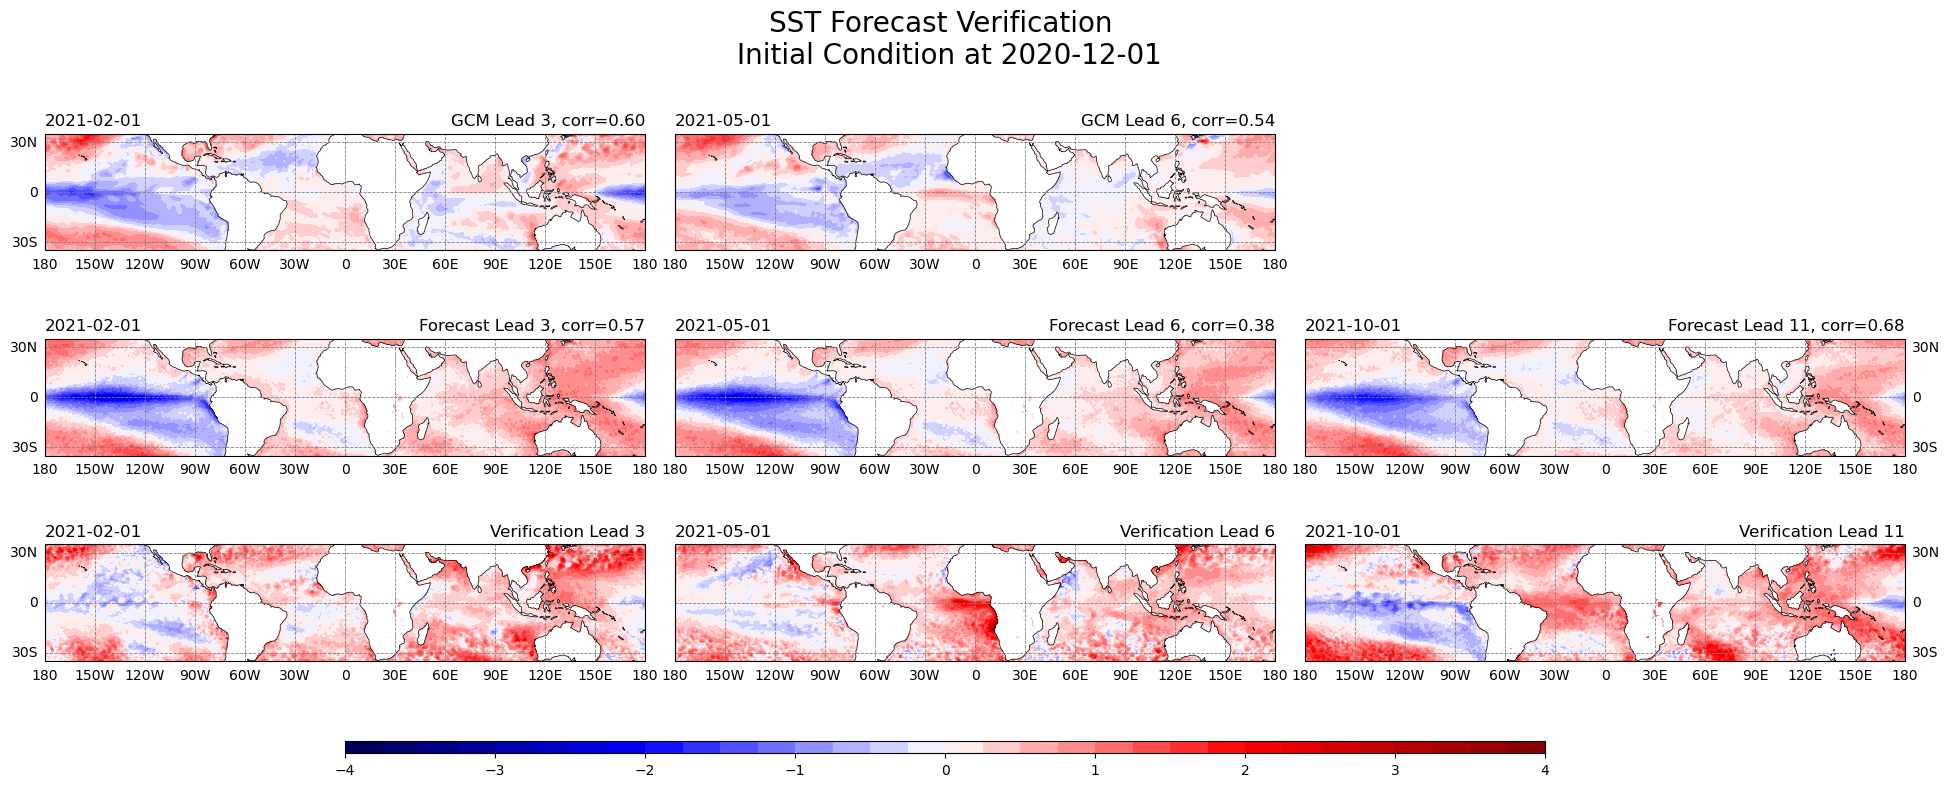

In [66]:
# Best Forecast
cday = 6
im = np.argmax(corrresult[cday,:])
im, corrresult[cday,im]
im=12
Cont = namedtuple('Contours', 'max min int')
cont_ = Cont(4, -4, 0.25)
np.arange(cont_.min,cont_.max,cont_.int)
cont=[cont_.min, cont_.max, cont_.int]
this_forecast = str(F.time.isel(time=im).data[()]).split('T')[0]

# Correlation for the pictures
loc_dyn = np.concatenate((np.ones((1, corrdyn.shape[1])), corrdyn), axis=0)
leads = [3,6,11]
labels_forecast = [f'corr={corrresult[i,im]:.2f}' for i in leads]
labels_GCM = [f'corr={loc_dyn[i, im]:.2f}' for i in leads if i < 7]


tit = f'SST Forecast Verification \n Initial Condition at {this_forecast}'
utp.Forecast_plots(F, V, NEW_DYN, '', None, cont, this_forecast, leads=leads, title=tit, colorbars=False, \
                   figsize=(24,8),mainlabel='', picturelabels=[labels_forecast,labels_GCM],\
                   arealatz=arealatz, arealonz=arealonz, centlon=PDX[plfield]['centlon'],labfile=f'SSTFcst_Best{cday}.pdf')


 Opening figure , 2 rows and 1 cols 

Ten Contours automatic
Ten Contours automatic


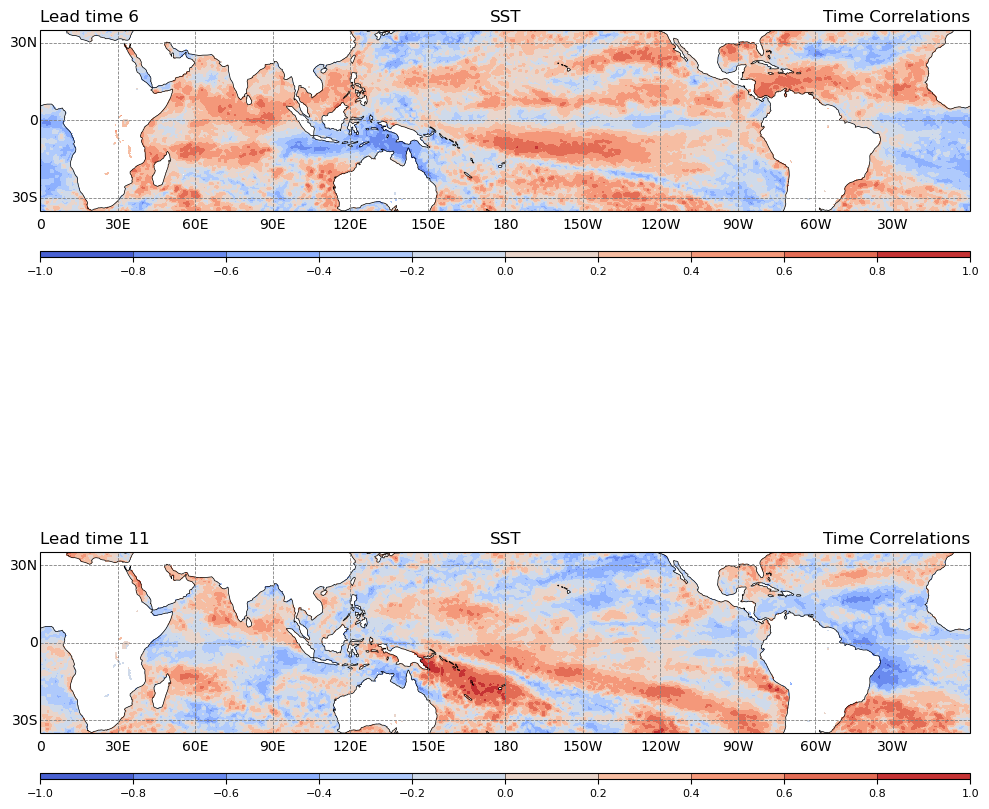

In [67]:
#Plot time correlation
Nplfield = INX[plfield]['mr']

nameeof = zai.select_field_key(INX,plfield,'field')

arealat = zai.select_field_key(INX,plfield,'arealat')

plpro = 'Pacific'
if INX[plfield]['area'] == 'EUROPE':
    plpro = 'Atlantic'
slim=4.0
cont1=[-slim,slim,0.5]
cont2=[-slim,slim,0.5]
cont1=[]
cont2=[]

if_time = [6,11]
label1 = 'Time Correlations'


xcc0=xr.corr(F[:,if_time[0],:], V[:,if_time[0],:],dim='time')
xcc1=xr.corr(F[:,if_time[1],:], V[:,if_time[1],:],dim='time')


fig,ax,pro=zmap.init_figure(2,1,plpro, constrained_layout=False, figsize=(12,12) )
handle=zmap.xmap(xcc0.unstack(),cont1, pro, ax=ax[0],refline=None, c_format='{:4.2f}',data_cent_lon=INX[plfield]['centlon'],\
                       xlimit=(arealon[0],arealon[1]), ylimit=(arealat[1],arealat[0]),
                 title={'maintitle':'SST', 'lefttitle':f'Lead time {if_time[0]}','righttitle':label1},cmap='coolwarm',contour=False)
zmap.add_colorbar(fig, handle['filled'], ax[0], label_size=8,edges=True)
# ax[1].projection = zmap.choose_projection('Atlantic')
han1=zmap.xmap(xcc1.unstack(), cont2, plpro, ax=ax[1], refline=None,c_format='{:4.2f}',data_cent_lon=INX[plfield]['centlon'],\
                       xlimit=(arealon[0],arealon[1]),ylimit=(arealat[1],arealat[0]),
               title={'maintitle':'SST', 'lefttitle':f'Lead time {if_time[1]}','righttitle':label1},cmap='coolwarm',contour=False)
zmap.add_colorbar(fig, han1['filled'], ax[1],label_size=8,edges=True)
fig.subplots_adjust(wspace=0.1,hspace=0.3)
labfile =  f'EOF{data_name}SST{period}.pdf'
# plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show()